In [1]:
import os
import warnings
import selenium
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_dq as pdq
import dataframe_image as dfi
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

warnings.filterwarnings("ignore")

# CARICAMENTO DEL DATASET

In [2]:
path = os.path.join(os.getcwd(), "wine_quality", "winequality-white.csv")

df = pd.read_csv(path, sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


## Rappresentazione grafica del dataset

Ogni grafico mostra la distribuzione dei valori di ogni colonna del dataset

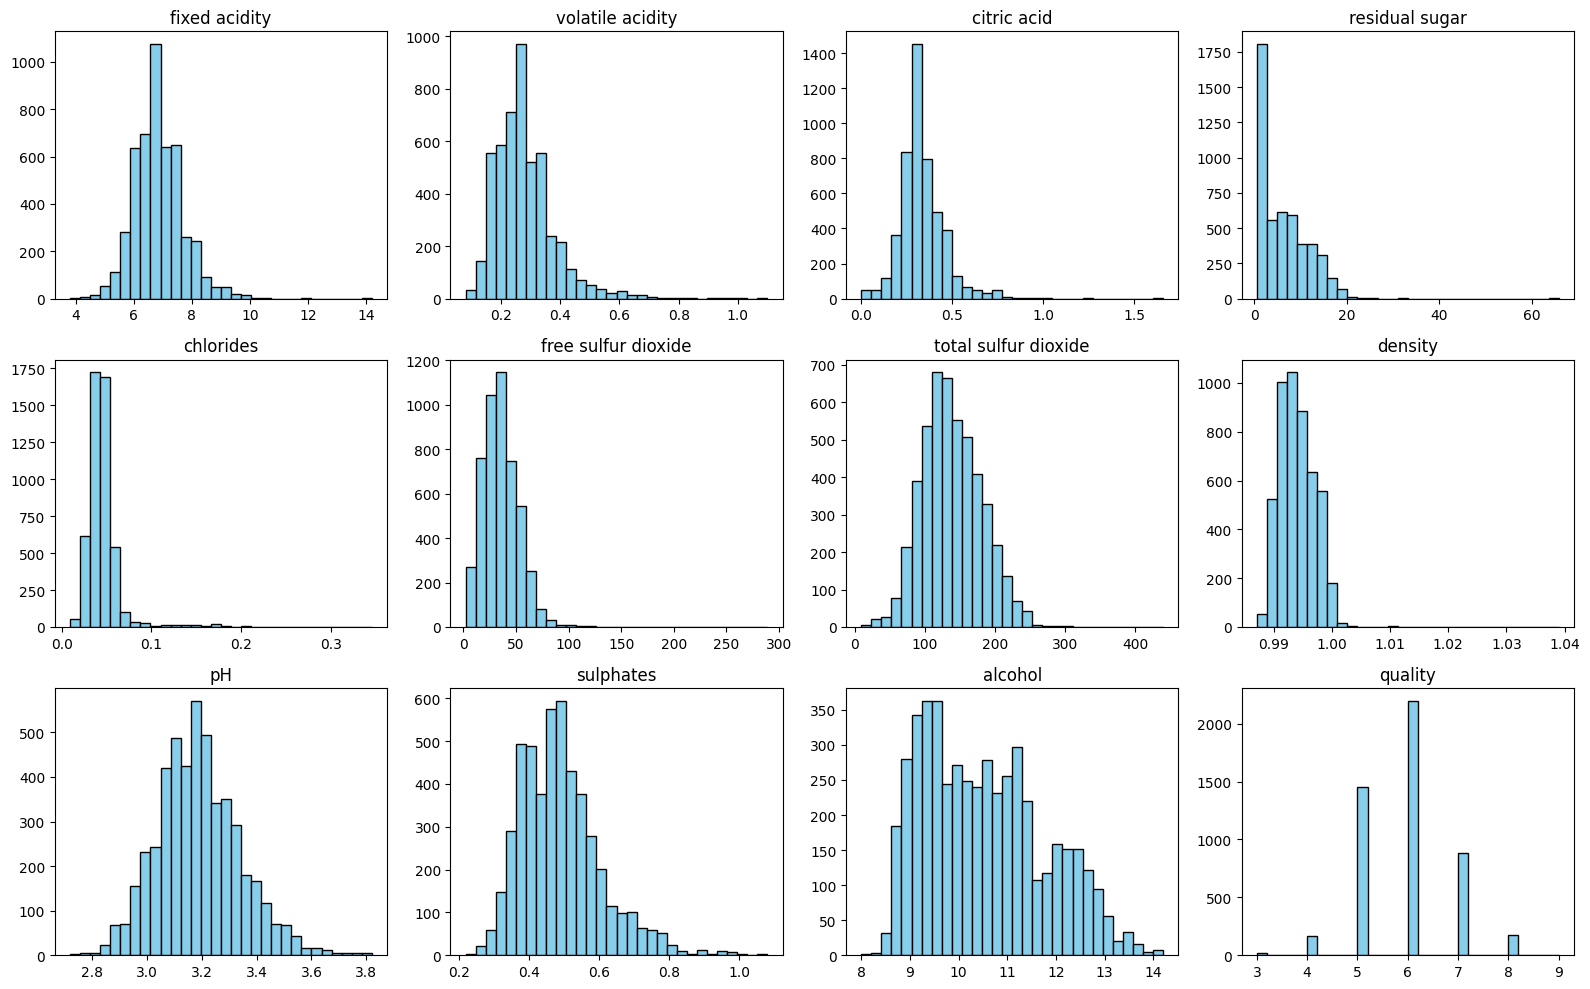

In [3]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor="black")
    plt.title(col)
    plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "data_distribution.png"))
plt.show()

## ANALISI ESPLORATIVA

Andiamo adesso ad analizzare il dataset, utilizzando sia funzioni scritte ad hoc che la libreria pandas_dq.
Ci verrà fatto un report sul dataset che evidenzierà i problemi del nostro dataset, come gli outliers e le features superflue dovute ad un'alta correlazione tra colonne

In [4]:
print(f"Dimensioni del dataset: {df.shape[0]} campioni, {df.shape[1]} features")

dqr = pdq.dq_report(df, target='quality', verbose=1)


dqr.dfi.export(os.path.join(os.getcwd(), "immagini_progetto", "data_quality_report.png"), table_conversion='selenium', dpi=160)

Dimensioni del dataset: 4898 campioni, 12 features
There are 937 duplicate rows in your dataset
    Alert: Dropping duplicate rows can sometimes cause your column data types to change to object!
    All variables classified into correct types.


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
fixed acidity,float64,0.000000,NA,3.800000,14.200000,Column has 106 outliers greater than upper bound (8.80) or lower than lower bound(4.80). Cap them or remove them.
volatile acidity,float64,0.000000,NA,0.080000,1.100000,Column has 133 outliers greater than upper bound (0.51) or lower than lower bound(0.03). Cap them or remove them.
citric acid,float64,0.000000,NA,0.000000,1.660000,Column has 223 outliers greater than upper bound (0.57) or lower than lower bound(0.09). Cap them or remove them.
residual sugar,float64,0.000000,NA,0.600000,65.800000,Column has 16 outliers greater than upper bound (19.85) or lower than lower bound(-9.35). Cap them or remove them.
chlorides,float64,0.000000,NA,0.009000,0.346000,Column has 178 outliers greater than upper bound (0.07) or lower than lower bound(0.01). Cap them or remove them.
free sulfur dioxide,float64,0.000000,NA,2.000000,289.000000,Column has 44 outliers greater than upper bound (78.00) or lower than lower bound(-10.00). Cap them or remove them.
total sulfur dioxide,float64,0.000000,NA,9.000000,440.000000,Column has 14 outliers greater than upper bound (256.00) or lower than lower bound(16.00). Cap them or remove them.
density,float64,0.000000,NA,0.987110,1.038980,"Column has 6 outliers greater than upper bound (1.00) or lower than lower bound(0.99). Cap them or remove them., Column has a high correlation with ['residual sugar']. Consider dropping one of them."
pH,float64,0.000000,NA,2.720000,3.820000,Column has 46 outliers greater than upper bound (3.59) or lower than lower bound(2.79). Cap them or remove them.
sulphates,float64,0.000000,NA,0.220000,1.080000,Column has 96 outliers greater than upper bound (0.76) or lower than lower bound(0.20). Cap them or remove them.


## STATISTICHE DESCRITTIVE

In [5]:
print(f"Memoria usata dal dataframe: {df.memory_usage(deep=True).sum() / 1024 :.2f} kB")

# Completiamo il dataframe aggiungendo le informazioni mancanti per gli outliers
describe_df = df.describe(include="all").T
describe_df['IQR'] = describe_df['75%'] - describe_df['25%']
describe_df['lower bound'] = describe_df['25%'] - 1.5 * describe_df['IQR']
describe_df['upper bound'] = describe_df['75%'] + 1.5 * describe_df['IQR']

describe_df.dfi.export(os.path.join(os.getcwd(), "immagini_progetto", "data_descriptive_statistics.png"), dpi=160, table_conversion='selenium')

describe_df.round(2)

Memoria usata dal dataframe: 459.32 kB


,count,mean,std,min,25%,50%,75%,max,IQR,lower bound,upper bound
fixed acidity,4898.0,6.85,0.84,3.80,6.30,6.80,7.30,14.20,1.00,4.80,8.80
volatile acidity,4898.0,0.28,0.10,0.08,0.21,0.26,0.32,1.10,0.11,0.04,0.49
citric acid,4898.0,0.33,0.12,0.00,0.27,0.32,0.39,1.66,0.12,0.09,0.57
residual sugar,4898.0,6.39,5.07,0.60,1.70,5.20,9.90,65.80,8.20,-10.60,22.20
chlorides,4898.0,0.05,0.02,0.01,0.04,0.04,0.05,0.35,0.01,0.01,0.07
free sulfur dioxide,4898.0,35.31,17.01,2.00,23.00,34.00,46.00,289.00,23.00,-11.50,80.50
total sulfur dioxide,4898.0,138.36,42.50,9.00,108.00,134.00,167.00,440.00,59.00,19.50,255.50
density,4898.0,0.99,0.00,0.99,0.99,0.99,1.00,1.04,0.00,0.99,1.00
pH,4898.0,3.19,0.15,2.72,3.09,3.18,3.28,3.82,0.19,2.80,3.56
sulphates,4898.0,0.49,0.11,0.22,0.41,0.47,0.55,1.08,0.14,0.20,0.76


### QUARTILI

In [6]:
describe_df[['25%', '75%', 'IQR']]

,25%,75%,IQR
fixed acidity,6.300000,7.3000,1.000000
volatile acidity,0.210000,0.3200,0.110000
citric acid,0.270000,0.3900,0.120000
residual sugar,1.700000,9.9000,8.200000
chlorides,0.036000,0.0500,0.014000
free sulfur dioxide,23.000000,46.0000,23.000000
total sulfur dioxide,108.000000,167.0000,59.000000
density,0.991723,0.9961,0.004377
pH,3.090000,3.2800,0.190000
sulphates,0.410000,0.5500,0.140000


# MATRICE DI CORRELAZIONE

Dal report notiamo che ci viene consigliata di droppare una colonna tra _density_ e _residual sugar_ per la presenza di un'alta correlazione tra le due colonne. Calcoliamo così quindi la matrice di correlazione per trovare eventuali altre colonne da poter droppare

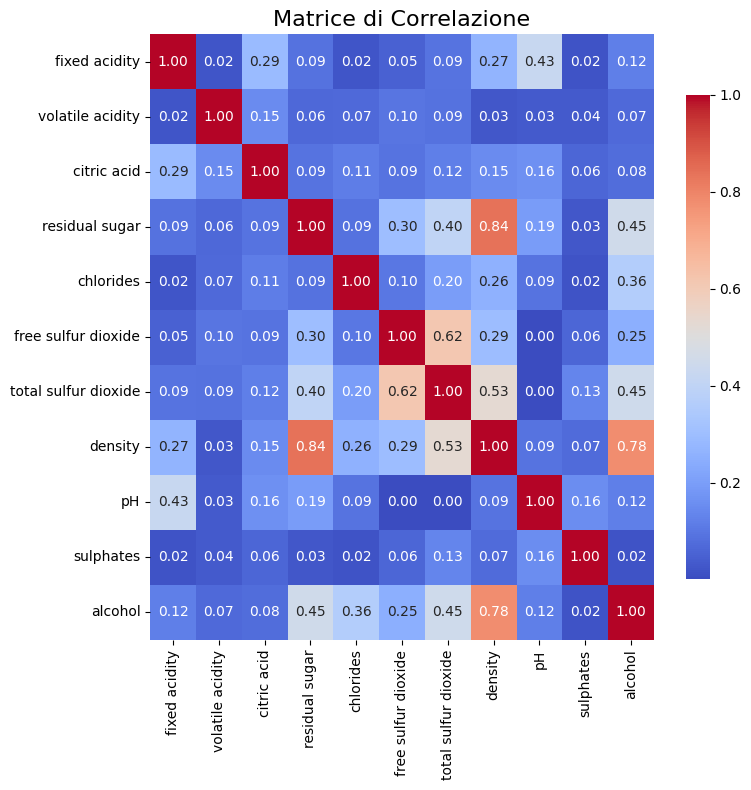

In [7]:
df_features = df.drop(columns=['quality'])
correlation_matrix = df_features.corr().abs()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"shrink": .8})
plt.title("Matrice di Correlazione", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "correlation_matrix.png"))
plt.show()


Notiamo anche altre alte correlazioni, come tra _density_ e _alcohol_

Secondo il report, l'unica correlazione "degna di nota" è quella tra density e residual sugar. Basandoci anche sul numero di outliers presenti per colonna, andremo a droppare la colonna residual sugar, presentando un numero di outliers maggiori rispetto a density.

In [8]:
processed_df = df.drop(columns=['residual sugar'])
dqr = pdq.dq_report(processed_df, verbose=1, target='quality')

There are 942 duplicate rows in your dataset
    Alert: Dropping duplicate rows can sometimes cause your column data types to change to object!
    All variables classified into correct types.


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
fixed acidity,float64,0.000000,NA,3.800000,14.200000,Column has 106 outliers greater than upper bound (8.80) or lower than lower bound(4.80). Cap them or remove them.
volatile acidity,float64,0.000000,NA,0.080000,1.100000,Column has 133 outliers greater than upper bound (0.51) or lower than lower bound(0.03). Cap them or remove them.
citric acid,float64,0.000000,NA,0.000000,1.660000,Column has 223 outliers greater than upper bound (0.57) or lower than lower bound(0.09). Cap them or remove them.
chlorides,float64,0.000000,NA,0.009000,0.346000,Column has 178 outliers greater than upper bound (0.07) or lower than lower bound(0.01). Cap them or remove them.
free sulfur dioxide,float64,0.000000,NA,2.000000,289.000000,Column has 44 outliers greater than upper bound (78.00) or lower than lower bound(-10.00). Cap them or remove them.
total sulfur dioxide,float64,0.000000,NA,9.000000,440.000000,Column has 14 outliers greater than upper bound (256.00) or lower than lower bound(16.00). Cap them or remove them.
density,float64,0.000000,NA,0.987110,1.038980,Column has 6 outliers greater than upper bound (1.00) or lower than lower bound(0.99). Cap them or remove them.
pH,float64,0.000000,NA,2.720000,3.820000,Column has 46 outliers greater than upper bound (3.59) or lower than lower bound(2.79). Cap them or remove them.
sulphates,float64,0.000000,NA,0.220000,1.080000,Column has 96 outliers greater than upper bound (0.76) or lower than lower bound(0.20). Cap them or remove them.
alcohol,float64,0.000000,NA,8.000000,14.200000,No issue


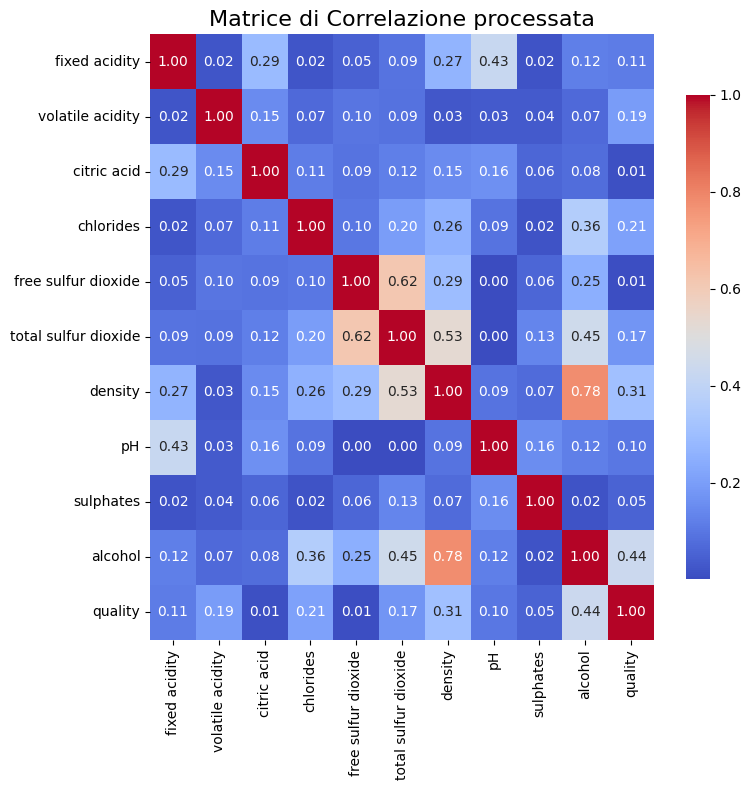

In [9]:
correlation_matrix = processed_df.corr().abs()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"shrink": .8})
plt.title("Matrice di Correlazione processata", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "correlation_matrix_processed.png"))
plt.show()

# OUTLIERS

Calcoliamo ora i valori del dataframe che risultano essere degli outliers.

Un outliers è un valore che risulta esterno all'intervallo di distribuzione del 99.7%

Avremo come estremi dell'intervallo gli estremi:
$$ LB = Q_1 - 1.5 * IQR $$
$$ UB = Q_3 + 1.5 * IQR $$

Dove il valore $IQR$ indica l'Interquantile Range, calcolato come la differenza tra terzo e primo quartile 
$$ IQR = Q_3 - Q_1 $$

In [10]:
outliers_df = pd.DataFrame()
outliers_idx = []
df_copy = processed_df.copy().drop(columns=['quality'])

num_cols = df_copy.select_dtypes(include=['float64', 'int64']).columns.to_list()

if len(num_cols) > 0:
    outliers_cols = []
    for col in num_cols:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_copy[(df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)][col]
        if not outliers.empty:
            outliers_cols.append(col)
            outliers_df = pd.concat([outliers_df, outliers], axis=1)
            outliers_df.fillna(0, inplace=True)

outliers_df.sort_index(inplace=True)

outliers_df['outlier count'] = (outliers_df != 0).sum(axis=1)
print(f"Numero di righe con presenza di outliers: {outliers_df.__len__()}")

outliers_idx = outliers_df.index.tolist().sort()

outliers_df

Numero di righe con presenza di outliers: 882


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,outlier count
14,0.0,0.00,0.62,0.000,0.0,0.0,0.0,0.0,0.00,1
16,0.0,0.00,0.04,0.000,0.0,0.0,0.0,0.0,0.00,1
17,0.0,0.66,0.00,0.000,0.0,0.0,0.0,0.0,0.00,1
20,0.0,0.66,0.00,0.000,0.0,0.0,0.0,0.0,0.00,1
23,0.0,0.67,0.00,0.074,0.0,0.0,0.0,0.0,0.00,2
...,...,...,...,...,...,...,...,...,...,...
4867,0.0,0.60,0.00,0.000,0.0,0.0,0.0,0.0,0.00,1
4877,0.0,0.54,0.00,0.000,0.0,0.0,0.0,0.0,0.00,1
4878,0.0,0.53,0.02,0.000,0.0,0.0,0.0,0.0,0.00,2
4886,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0,1.08,1


Abbiamo ora trovato tutti gli outliers del nostro dataset. Per valutare al meglio questo dataset si potrebbero o rimuovere o "limarli", ovvero portarli al valore massimo o minimo possibile, in base a quale estremo abbiano superato. Nel nostro caso andremo a rimuovere del tutto queste righe

## LABELLAZIONE TARGET

Applichiamo ora un label alle classi della variabile target _quality_, separando le classi in:
 - bassa, per valori compresi tra 0 e 4
 - media, per valori compresi tra 5 e 7
 - alta, per valori compresi tra 8 e 9


In [11]:
def quality_label(quality):
    if quality in range(0, 5):
        return 'bassa'
    elif quality in range(5, 8):
        return 'media'
    else:
        return 'alta'

Valutiamo ora la distribuzione

In [12]:
df_quality = pd.DataFrame(processed_df['quality'].copy().value_counts().sort_index()).reset_index()
df_quality['class'] = df_quality['quality'].apply(quality_label)
df_quality


,quality,count,class
0,3,20,bassa
1,4,163,bassa
2,5,1457,media
3,6,2198,media
4,7,880,media
5,8,175,alta
6,9,5,alta


In [101]:
df_quality_class = df_quality.groupby('class').sum().reset_index()
df_quality_class

,class,quality,count
0,alta,17,180
1,bassa,7,183
2,media,18,4535


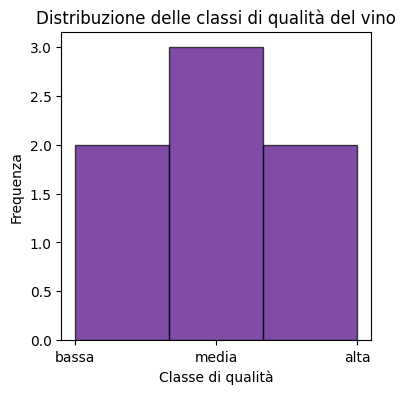

In [13]:
plt.figure(figsize=(4, 4))
plt.hist(df_quality["class"], bins=len(df_quality["class"].unique()), color='indigo', alpha=0.7, rwidth=1, align='mid', edgecolor='black')
plt.title("Distribuzione delle classi di qualità del vino")
plt.xlabel("Classe di qualità")
plt.ylabel("Frequenza")
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "quality_class_distribution.png"))
plt.show()

In [14]:
processed_df_copy = processed_df.drop(outliers_df.index).reset_index(drop=True)
print(f"Dimensioni del dataset dopo la rimozione degli outliers: {processed_df_copy.shape[0]} campioni, {processed_df_copy.shape[1]} features")

processed_df_copy

Dimensioni del dataset dopo la rimozione degli outliers: 4016 campioni, 11 features


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...
4011,6.2,0.21,0.29,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4012,6.6,0.32,0.36,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4013,6.5,0.24,0.19,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4014,5.5,0.29,0.30,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# MODELLO 1: DATI GREZZI

Addestriamo ora due classificatori, il Random Forest Classifier e il Gradient Boosting Classifier. Prenderemo il dataset di partenza, addestreremo 3 modelli a random forest, dividendo in maniera diversa il dataset tra train e test, e un modello a gradient boosting

In [15]:
df_raw = df.copy()
df.describe(include='all').round(2).T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.85,0.84,3.80,6.30,6.80,7.30,14.20
volatile acidity,4898.0,0.28,0.10,0.08,0.21,0.26,0.32,1.10
citric acid,4898.0,0.33,0.12,0.00,0.27,0.32,0.39,1.66
residual sugar,4898.0,6.39,5.07,0.60,1.70,5.20,9.90,65.80
chlorides,4898.0,0.05,0.02,0.01,0.04,0.04,0.05,0.35
free sulfur dioxide,4898.0,35.31,17.01,2.00,23.00,34.00,46.00,289.00
total sulfur dioxide,4898.0,138.36,42.50,9.00,108.00,134.00,167.00,440.00
density,4898.0,0.99,0.00,0.99,0.99,0.99,1.00,1.04
pH,4898.0,3.19,0.15,2.72,3.09,3.18,3.28,3.82
sulphates,4898.0,0.49,0.11,0.22,0.41,0.47,0.55,1.08


In [16]:
x_raw = df_raw.drop(columns=['quality'], axis=1)
y_raw = df_raw['quality']

In [17]:
x_train_raw1, x_test_raw1, y_train_raw1, y_test_raw1 = train_test_split(x_raw, y_raw, test_size=0.2, random_state=42) # test size 0.2
x_train_raw2, x_test_raw2, y_train_raw2, y_test_raw2 = train_test_split(x_raw, y_raw, test_size=0.25, random_state=42) # test size 0.25
x_train_raw3, x_test_raw3, y_train_raw3, y_test_raw3 = train_test_split(x_raw, y_raw, test_size=0.3, random_state=42) # test size 0.3

print(f"Dimensioni del dataset di training (test size 0.2): {x_train_raw1.shape[0]} campioni, {x_train_raw1.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.2): {x_test_raw1.shape[0]} campioni, {x_test_raw1.shape[1]} features\n")

print(f"Dimensioni del dataset di training (test size 0.25): {x_train_raw2.shape[0]} campioni, {x_train_raw2.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.25): {x_test_raw2.shape[0]} campioni, {x_test_raw2.shape[1]} features\n")

print(f"Dimensioni del dataset di training (test size 0.3): {x_train_raw3.shape[0]} campioni, {x_train_raw3.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.3): {x_test_raw3.shape[0]} campioni, {x_test_raw3.shape[1]} features\n")

Dimensioni del dataset di training (test size 0.2): 3918 campioni, 11 features
Dimensioni del dataset di test (test size 0.2): 980 campioni, 11 features

Dimensioni del dataset di training (test size 0.25): 3673 campioni, 11 features
Dimensioni del dataset di test (test size 0.25): 1225 campioni, 11 features

Dimensioni del dataset di training (test size 0.3): 3428 campioni, 11 features
Dimensioni del dataset di test (test size 0.3): 1470 campioni, 11 features



In [18]:
# Verifica dei valori nulli
print(f"Valori nulli nel dataset di training (test size 0.2): {x_train_raw1.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.2): {x_test_raw1.isnull().sum().sum()}\n")
print(f"Valori nulli nel dataset di training (test size 0.25): {x_train_raw2.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.25): {x_test_raw2.isnull().sum().sum()}\n")
print(f"Valori nulli nel dataset di training (test size 0.3): {x_train_raw3.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.3): {x_test_raw3.isnull().sum().sum()}\n")

Valori nulli nel dataset di training (test size 0.2): 0
Valori nulli nel dataset di test (test size 0.2): 0

Valori nulli nel dataset di training (test size 0.25): 0
Valori nulli nel dataset di test (test size 0.25): 0

Valori nulli nel dataset di training (test size 0.3): 0
Valori nulli nel dataset di test (test size 0.3): 0



In [19]:
rf_100_raw = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf_100_raw.fit(x_train_raw1, y_train_raw1)

rf_110_raw = RandomForestClassifier(n_estimators=110, random_state=42, verbose=1)
rf_110_raw.fit(x_train_raw1, y_train_raw1)

rf_120_raw = RandomForestClassifier(n_estimators=120, random_state=42, verbose=1)
rf_120_raw.fit(x_train_raw1, y_train_raw1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.4s finished


,n_estimators,120
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
predict_value_rf = {
    "0": 0,
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0,
    "6": 0,
    "7": 0,
    "8": 0,
    "9": 0,
}

predict_value_rf

{'0': 0,
 '1': 0,
 '2': 0,
 '3': 0,
 '4': 0,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0}

In [21]:
y_pred_100_20_raw_rf = rf_100_raw.predict(x_test_raw1)
y_pred_110_20_raw_rf = rf_110_raw.predict(x_test_raw1)
y_pred_120_20_raw_rf = rf_120_raw.predict(x_test_raw1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [22]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_20_raw_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_20_raw_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_20_raw_rf:
    predict_value_rf_120[str(value)] += 1

In [23]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})
prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,10,10,10
5,286,282,278
6,517,521,527
7,147,147,145
8,20,20,20
9,0,0,0


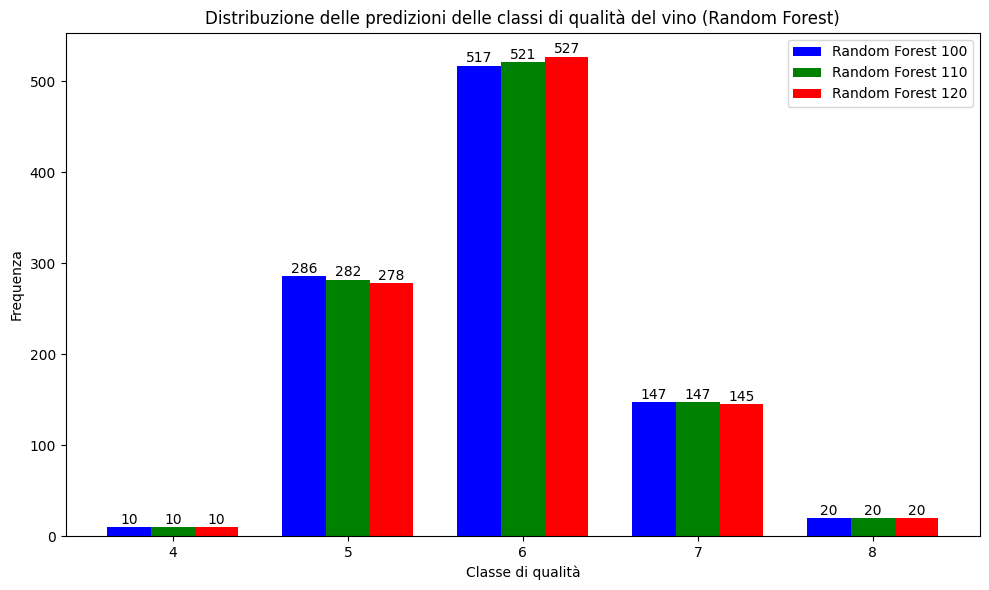

In [24]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_20.png"))
plt.show()

In [25]:
accuracy_100_20_rf = accuracy_score(y_test_raw1, y_pred_100_20_raw_rf)
accuracy_110_20_rf = accuracy_score(y_test_raw1, y_pred_110_20_raw_rf)
accuracy_120_20_rf = accuracy_score(y_test_raw1, y_pred_120_20_raw_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_20_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_20_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_20_rf * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 68.98%
Accuratezza del modello Random Forest con 110 alberi: 68.88%
Accuratezza del modello Random Forest con 120 alberi: 69.80%


In [26]:
rf_100_raw.fit(x_train_raw2, y_train_raw2)
rf_110_raw.fit(x_train_raw2, y_train_raw2)
rf_120_raw.fit(x_train_raw2, y_train_raw2)

y_pred_100_25_raw_rf = rf_100_raw.predict(x_test_raw2)
y_pred_110_25_raw_rf = rf_110_raw.predict(x_test_raw2)
y_pred_120_25_raw_rf = rf_120_raw.predict(x_test_raw2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [27]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_25_raw_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_25_raw_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_25_raw_rf:
    predict_value_rf_120[str(value)] += 1

In [28]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})
prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,9,9,9
5,342,343,345
6,683,680,674
7,175,177,181
8,16,16,16
9,0,0,0


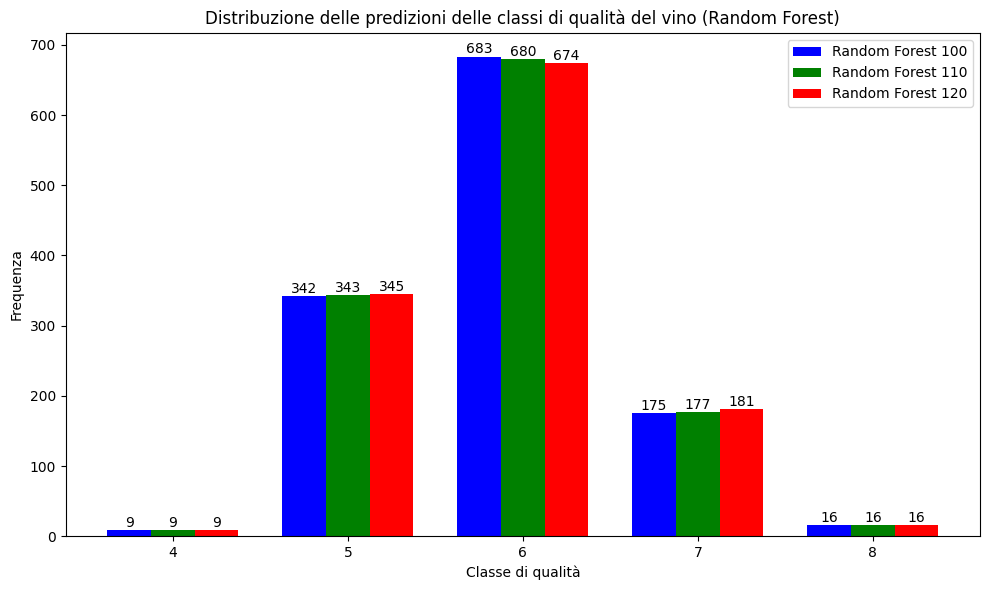

In [29]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_25.png"))
plt.show()

In [30]:
accuracy_100_25_rf = accuracy_score(y_test_raw2, y_pred_100_25_raw_rf)
accuracy_110_25_rf = accuracy_score(y_test_raw2, y_pred_110_25_raw_rf)
accuracy_120_25_rf = accuracy_score(y_test_raw2, y_pred_120_25_raw_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_25_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_25_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_25_rf * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 67.18%
Accuratezza del modello Random Forest con 110 alberi: 67.59%
Accuratezza del modello Random Forest con 120 alberi: 67.92%


In [31]:
rf_100_raw.fit(x_train_raw3, y_train_raw3)
rf_110_raw.fit(x_train_raw3, y_train_raw3)
rf_120_raw.fit(x_train_raw3, y_train_raw3)

y_pred_100_30_raw_rf = rf_100_raw.predict(x_test_raw3)
y_pred_110_30_raw_rf = rf_110_raw.predict(x_test_raw3)
y_pred_120_30_raw_rf = rf_120_raw.predict(x_test_raw3)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [32]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_30_raw_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_30_raw_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_30_raw_rf:
    predict_value_rf_120[str(value)] += 1

In [33]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})
prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,8,10,11
5,445,445,444
6,795,791,792
7,199,203,202
8,23,21,21
9,0,0,0


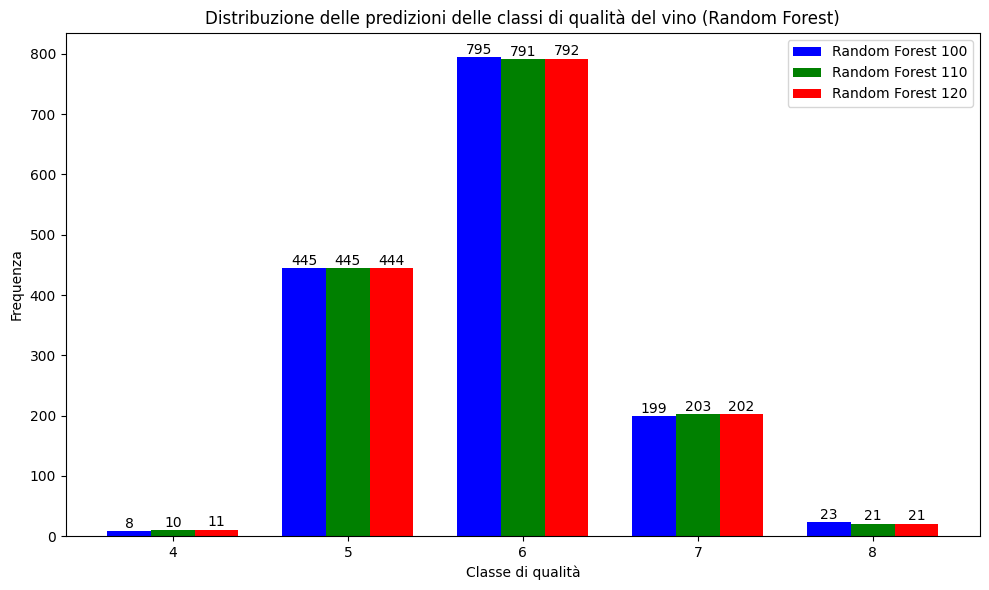

In [34]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_30.png"))
plt.show()

In [35]:
accuracy_100_30_rf = accuracy_score(y_test_raw3, y_pred_100_30_raw_rf)
accuracy_110_30_rf = accuracy_score(y_test_raw3, y_pred_110_30_raw_rf)
accuracy_120_30_rf = accuracy_score(y_test_raw3, y_pred_120_30_raw_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_30_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_30_rf * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_30_rf * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 67.96%
Accuratezza del modello Random Forest con 110 alberi: 68.23%
Accuratezza del modello Random Forest con 120 alberi: 68.78%


In [36]:
gb_100_raw = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_110_raw = GradientBoostingClassifier(n_estimators=110, random_state=42)
gb_120_raw = GradientBoostingClassifier(n_estimators=120, random_state=42)

gb_100_raw.fit(x_train_raw1, y_train_raw1)
gb_110_raw.fit(x_train_raw1, y_train_raw1)
gb_120_raw.fit(x_train_raw1, y_train_raw1)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,120
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [37]:
y_pred_100_20_raw_gb = gb_100_raw.predict(x_test_raw1)
y_pred_110_20_raw_gb = gb_110_raw.predict(x_test_raw1)
y_pred_120_20_raw_gb = gb_120_raw.predict(x_test_raw1)

In [38]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_20_raw_gb:
    predict_value_gb_100[str(value)] += 1

predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_20_raw_gb:
    predict_value_gb_110[str(value)] += 1

predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_20_raw_gb:
    predict_value_gb_120[str(value)] += 1

In [39]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})
prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,3,3,3
4,14,14,14
5,269,272,266
6,567,563,567
7,113,116,118
8,14,12,12
9,0,0,0


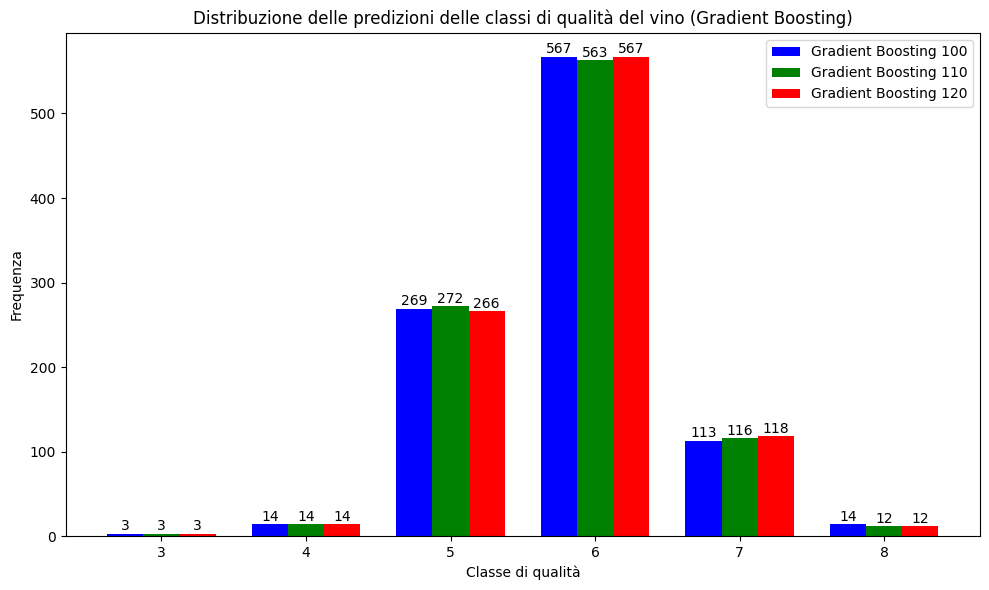

In [40]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boosting 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_20.png"))
plt.show()

In [41]:
accuracy_100_20_gb = accuracy_score(y_test_raw1, y_pred_100_20_raw_gb)
accuracy_110_20_gb = accuracy_score(y_test_raw1, y_pred_110_20_raw_gb)
accuracy_120_20_gb = accuracy_score(y_test_raw1, y_pred_120_20_raw_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_20_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_20_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_20_gb * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 57.45%
Accuratezza del modello Gradient Boosting con 110 estimatori: 57.04%
Accuratezza del modello Gradient Boosting con 120 estimatori: 57.96%


In [42]:
gb_100_raw.fit(x_train_raw2, y_train_raw2)
gb_110_raw.fit(x_train_raw2, y_train_raw2)
gb_120_raw.fit(x_train_raw2, y_train_raw2)

y_pred_100_25_raw_gb = gb_100_raw.predict(x_test_raw2)
y_pred_110_25_raw_gb = gb_110_raw.predict(x_test_raw2)
y_pred_120_25_raw_gb = gb_120_raw.predict(x_test_raw2)

In [43]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_25_raw_gb:
    predict_value_gb_100[str(value)] += 1

predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_25_raw_gb:
    predict_value_gb_110[str(value)] += 1

predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_25_raw_gb:
    predict_value_gb_120[str(value)] += 1

In [44]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})

prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,4,4,4
4,16,18,19
5,335,329,337
6,708,707,692
7,152,157,161
8,9,9,11
9,1,1,1


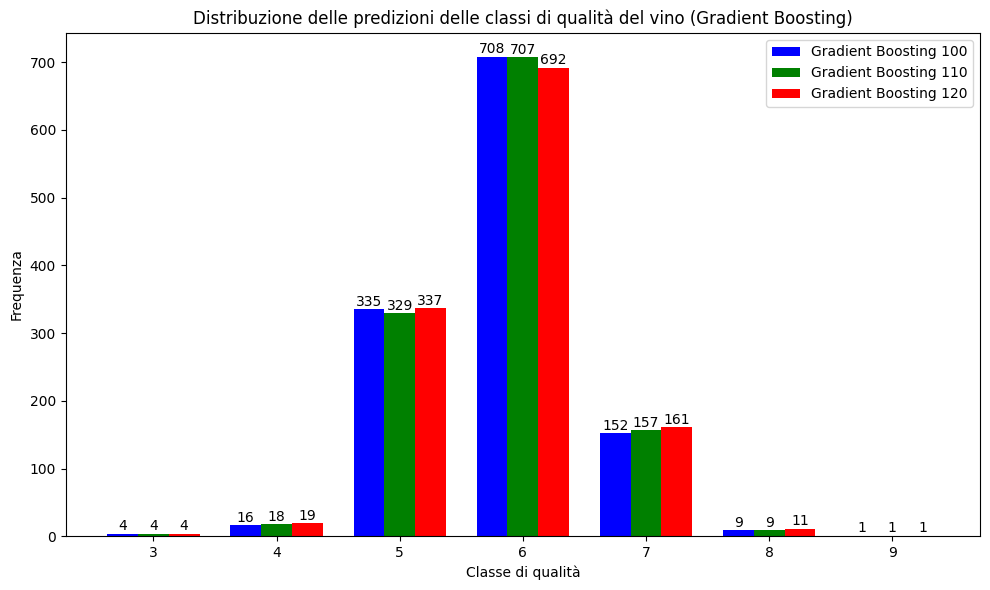

In [45]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boosting 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_25.png"))
plt.show()

In [46]:
accuracy_100_25_gb = accuracy_score(y_test_raw2, y_pred_100_25_raw_gb)
accuracy_110_25_gb = accuracy_score(y_test_raw2, y_pred_110_25_raw_gb)
accuracy_120_25_gb = accuracy_score(y_test_raw2, y_pred_120_25_raw_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_25_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_25_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_25_gb * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 56.98%
Accuratezza del modello Gradient Boosting con 110 estimatori: 57.71%
Accuratezza del modello Gradient Boosting con 120 estimatori: 58.45%


In [47]:
gb_100_raw.fit(x_train_raw3, y_train_raw3)
gb_110_raw.fit(x_train_raw3, y_train_raw3)
gb_120_raw.fit(x_train_raw3, y_train_raw3)

y_pred_100_30_raw_gb = gb_100_raw.predict(x_test_raw3)
y_pred_110_30_raw_gb = gb_110_raw.predict(x_test_raw3)
y_pred_120_30_raw_gb = gb_120_raw.predict(x_test_raw3)

In [48]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_30_raw_gb:
    predict_value_gb_100[str(value)] += 1

predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_30_raw_gb:
    predict_value_gb_110[str(value)] += 1

predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_30_raw_gb:
    predict_value_gb_120[str(value)] += 1

In [49]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})

prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,3,3,3
4,21,21,23
5,441,442,443
6,807,805,799
7,186,185,188
8,11,13,13
9,1,1,1


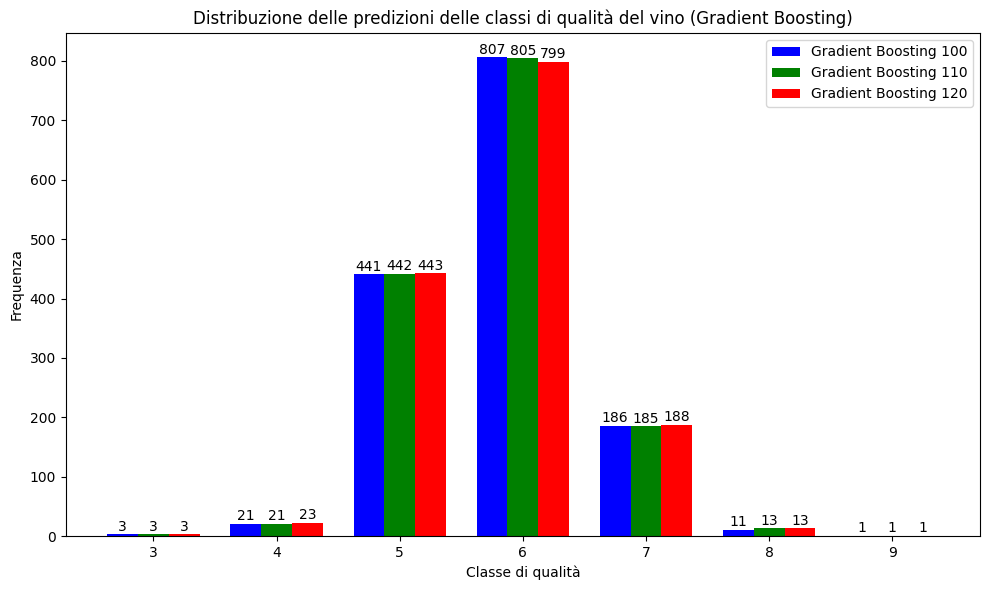

In [50]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boosting 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_30.png"))
plt.show()

In [51]:
accuracy_100_30_gb = accuracy_score(y_test_raw3, y_pred_100_30_raw_gb)
accuracy_110_30_gb = accuracy_score(y_test_raw3, y_pred_110_30_raw_gb)
accuracy_120_30_gb = accuracy_score(y_test_raw3, y_pred_120_30_raw_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_30_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_30_gb * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_30_gb * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 58.50%
Accuratezza del modello Gradient Boosting con 110 estimatori: 58.91%
Accuratezza del modello Gradient Boosting con 120 estimatori: 59.05%


# MODELLO 2: DATI PROCESSATI

In [52]:
processed_df_copy

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...
4011,6.2,0.21,0.29,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4012,6.6,0.32,0.36,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4013,6.5,0.24,0.19,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4014,5.5,0.29,0.30,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [53]:
x_processed = processed_df_copy.drop(columns=['quality'], axis=1)
y_processed = processed_df_copy['quality']

print(f"Features preprocessate: {x_processed.shape[0]} campioni, {x_processed.shape[1]} features")
print(f"Target preprocessate: {y_processed.shape[0]} campioni")

Features preprocessate: 4016 campioni, 10 features
Target preprocessate: 4016 campioni


In [54]:
x_train_processed_1, x_test_processed_1, y_train_processed_1, y_test_processed_1 = train_test_split(x_processed, y_processed, test_size=0.2, random_state=42) # test size 0.2
x_train_processed_2, x_test_processed_2, y_train_processed_2, y_test_processed_2 = train_test_split(x_processed, y_processed, test_size=0.25, random_state=42) # test size 0.25
x_train_processed_3, x_test_processed_3, y_train_processed_3, y_test_processed_3 = train_test_split(x_processed, y_processed, test_size=0.3, random_state=42) # test size 0.3

print(f"Dimensioni del dataset di training (test size 0.2): {x_train_processed_1.shape[0]} campioni, {x_train_processed_1.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.2): {x_test_processed_1.shape[0]} campioni, {x_test_processed_1.shape[1]} features\n")
print(f"Dimensioni del dataset di training (test size 0.25): {x_train_processed_2.shape[0]} campioni, {x_train_processed_2.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.25): {x_test_processed_2.shape[0]} campioni, {x_test_processed_2.shape[1]} features\n")
print(f"Dimensioni del dataset di training (test size 0.3): {x_train_processed_3.shape[0]} campioni, {x_train_processed_3.shape[1]} features")
print(f"Dimensioni del dataset di test (test size 0.3): {x_test_processed_3.shape[0]} campioni, {x_test_processed_3.shape[1]} features\n")

Dimensioni del dataset di training (test size 0.2): 3212 campioni, 10 features
Dimensioni del dataset di test (test size 0.2): 804 campioni, 10 features

Dimensioni del dataset di training (test size 0.25): 3012 campioni, 10 features
Dimensioni del dataset di test (test size 0.25): 1004 campioni, 10 features

Dimensioni del dataset di training (test size 0.3): 2811 campioni, 10 features
Dimensioni del dataset di test (test size 0.3): 1205 campioni, 10 features



In [55]:
scaler = StandardScaler()

In [56]:
x_train_processed_1_scaled = scaler.fit_transform(x_train_processed_1)
x_train_processed_1_scaled = pd.DataFrame(x_train_processed_1_scaled, columns=x_train_processed_1.columns)
x_test_processed_1_scaled = scaler.transform(x_test_processed_1)
x_test_processed_1_scaled = pd.DataFrame(x_test_processed_1_scaled, columns=x_test_processed_1.columns)

In [57]:
x_train_processed_2_scaled = scaler.fit_transform(x_train_processed_2)
x_train_processed_2_scaled = pd.DataFrame(x_train_processed_2_scaled, columns=x_train_processed_2.columns)
x_test_processed_2_scaled = scaler.transform(x_test_processed_2)
x_test_processed_2_scaled = pd.DataFrame(x_test_processed_2_scaled, columns=x_test_processed_2.columns)

In [58]:
x_train_processed_3_scaled = scaler.fit_transform(x_train_processed_3)
x_train_processed_3_scaled = pd.DataFrame(x_train_processed_3_scaled, columns=x_train_processed_3.columns)
x_test_processed_3_scaled = scaler.transform(x_test_processed_3)
x_test_processed_3_scaled = pd.DataFrame(x_test_processed_3_scaled, columns=x_test_processed_3.columns)

In [59]:
#Verifica dei valori nulli
print(f"Valori nulli nel dataset di training (test size 0.2): {x_train_processed_1_scaled.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.2): {x_test_processed_1_scaled.isnull().sum().sum()}\n")
print(f"Valori nulli nel dataset di training (test size 0.25): {x_train_processed_2_scaled.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.25): {x_test_processed_2_scaled.isnull().sum().sum()}\n")
print(f"Valori nulli nel dataset di training (test size 0.3): {x_train_processed_3_scaled.isnull().sum().sum()}")
print(f"Valori nulli nel dataset di test (test size 0.3): {x_test_processed_3_scaled.isnull().sum().sum()}\n")

Valori nulli nel dataset di training (test size 0.2): 0
Valori nulli nel dataset di test (test size 0.2): 0

Valori nulli nel dataset di training (test size 0.25): 0
Valori nulli nel dataset di test (test size 0.25): 0

Valori nulli nel dataset di training (test size 0.3): 0
Valori nulli nel dataset di test (test size 0.3): 0



In [60]:
rf_100_processed = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf_110_processed = RandomForestClassifier(n_estimators=110, random_state=42, verbose=1)
rf_120_processed = RandomForestClassifier(n_estimators=120, random_state=42, verbose=1)

In [61]:
rf_100_processed.fit(x_train_processed_1_scaled, y_train_processed_1)
rf_110_processed.fit(x_train_processed_1_scaled, y_train_processed_1)
rf_120_processed.fit(x_train_processed_1_scaled, y_train_processed_1)

y_pred_100_20_processed_rf = rf_100_processed.predict(x_test_processed_1_scaled)
y_pred_110_20_processed_rf = rf_110_processed.predict(x_test_processed_1_scaled)
y_pred_120_20_processed_rf = rf_120_processed.predict(x_test_processed_1_scaled)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [62]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_20_processed_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_20_processed_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_20_processed_rf:
    predict_value_rf_120[str(value)] += 1

In [63]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})

prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,7,7,7
5,196,195,196
6,461,463,469
7,129,128,121
8,11,11,11
9,0,0,0


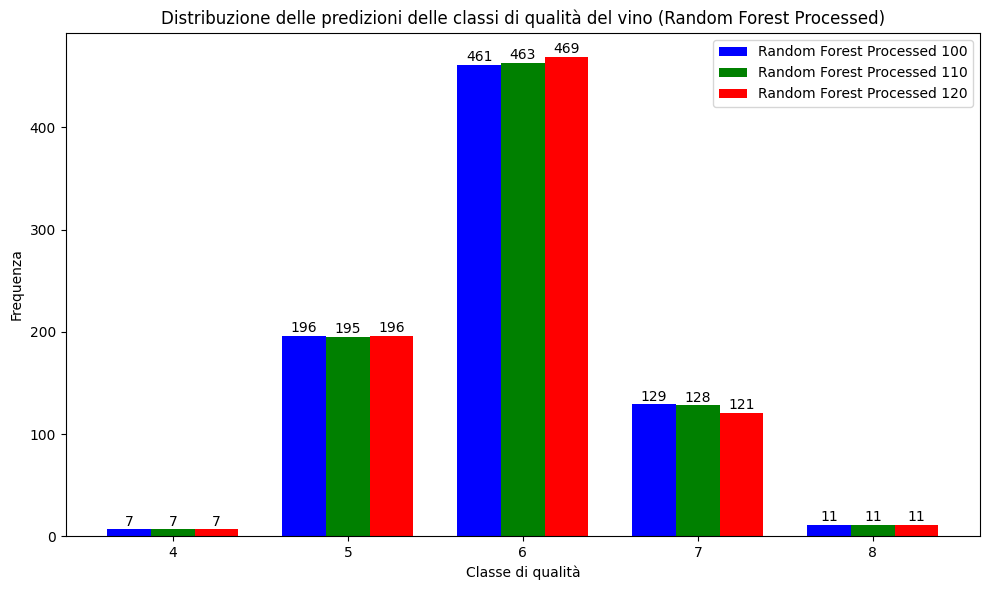

In [64]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_processed_20.png"))
plt.show()

In [65]:
accuracy_100_20_rfp = accuracy_score(y_test_processed_1, y_pred_100_20_processed_rf)
accuracy_110_20_rfp = accuracy_score(y_test_processed_1, y_pred_110_20_processed_rf)
accuracy_120_20_rfp = accuracy_score(y_test_processed_1, y_pred_120_20_processed_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_20_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_20_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_20_rfp * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 66.67%
Accuratezza del modello Random Forest con 110 alberi: 66.54%
Accuratezza del modello Random Forest con 120 alberi: 67.66%


In [66]:
rf_100_processed.fit(x_train_processed_2_scaled, y_train_processed_2)
rf_110_processed.fit(x_train_processed_2_scaled, y_train_processed_2)
rf_120_processed.fit(x_train_processed_2_scaled, y_train_processed_2)

y_pred_100_25_processed_rf = rf_100_processed.predict(x_test_processed_2_scaled)
y_pred_110_25_processed_rf = rf_110_processed.predict(x_test_processed_2_scaled)
y_pred_120_25_processed_rf = rf_120_processed.predict(x_test_processed_2_scaled)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [67]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_25_processed_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_25_processed_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_25_processed_rf:
    predict_value_rf_120[str(value)] += 1

In [68]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})

prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,6,6,6
5,250,250,249
6,572,572,573
7,161,161,161
8,15,15,15
9,0,0,0


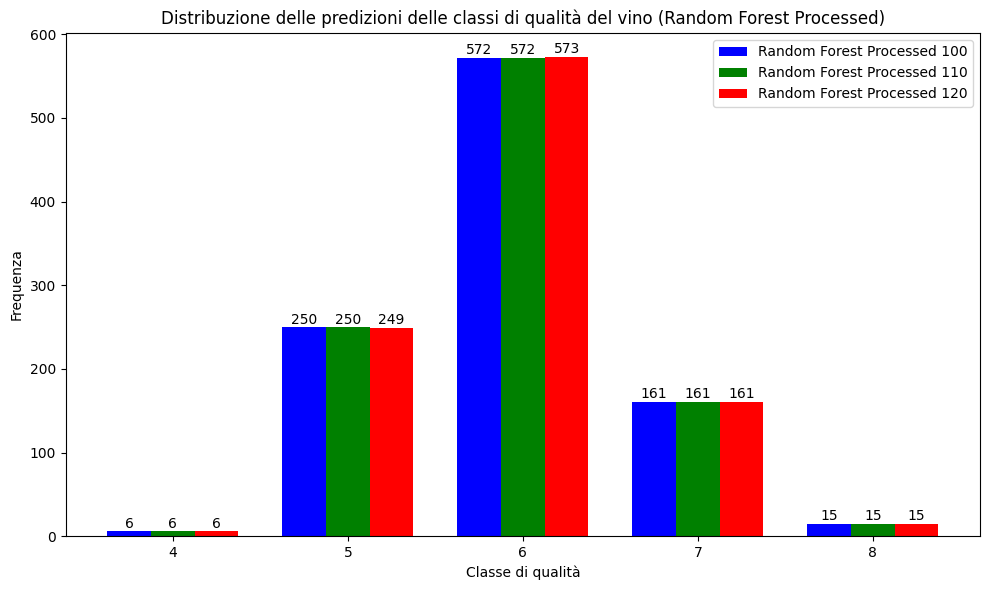

In [69]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_processed_25.png"))
plt.show()

In [70]:
accuracy_100_25_rfp = accuracy_score(y_test_processed_2, y_pred_100_25_processed_rf)
accuracy_110_25_rfp = accuracy_score(y_test_processed_2, y_pred_110_25_processed_rf)
accuracy_120_25_rfp = accuracy_score(y_test_processed_2, y_pred_120_25_processed_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_25_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_25_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_25_rfp * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 67.23%
Accuratezza del modello Random Forest con 110 alberi: 67.03%
Accuratezza del modello Random Forest con 120 alberi: 67.33%


In [71]:
rf_100_processed.fit(x_train_processed_3_scaled, y_train_processed_3)
rf_110_processed.fit(x_train_processed_3_scaled, y_train_processed_3)
rf_120_processed.fit(x_train_processed_3_scaled, y_train_processed_3)

y_pred_100_30_processed_rf = rf_100_processed.predict(x_test_processed_3_scaled)
y_pred_110_30_processed_rf = rf_110_processed.predict(x_test_processed_3_scaled)
y_pred_120_30_processed_rf = rf_120_processed.predict(x_test_processed_3_scaled)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [72]:
predict_value_rf_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_30_processed_rf:
    predict_value_rf_100[str(value)] += 1

predict_value_rf_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_30_processed_rf:
    predict_value_rf_110[str(value)] += 1

predict_value_rf_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_30_processed_rf:
    predict_value_rf_120[str(value)] += 1

In [73]:
prediction_df = pd.DataFrame({
    "Random Forest 100": predict_value_rf_100,
    "Random Forest 110": predict_value_rf_110,
    "Random Forest 120": predict_value_rf_120
})

prediction_df

,Random Forest 100,Random Forest 110,Random Forest 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,7,7,7
5,299,302,296
6,689,690,695
7,195,191,192
8,15,15,15
9,0,0,0


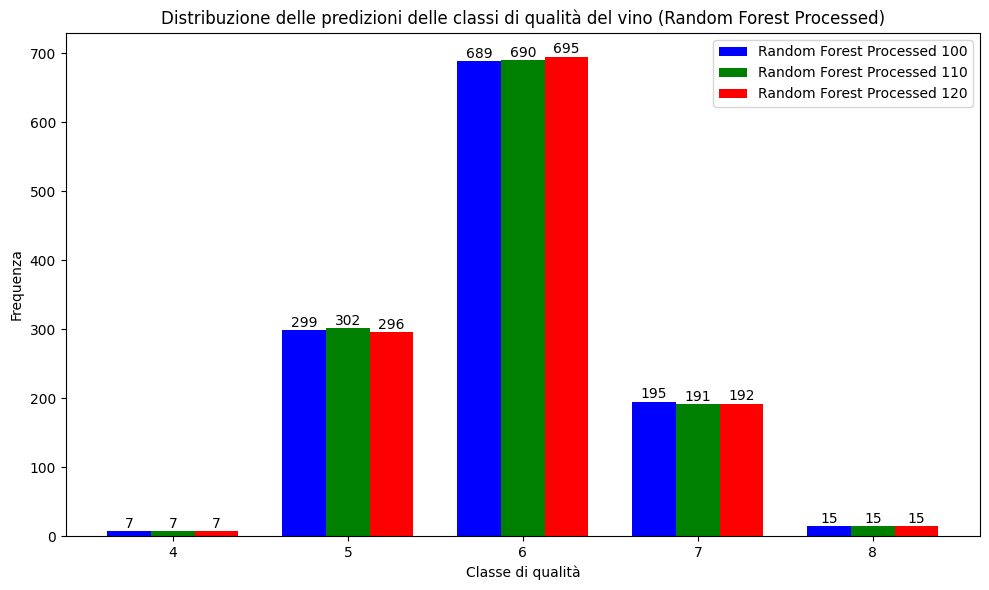

In [74]:
keys = list(predict_value_rf_100.keys())
vals_100 = np.array(list(predict_value_rf_100.values()))
vals_110 = np.array(list(predict_value_rf_110.values()))
vals_120 = np.array(list(predict_value_rf_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Random Forest Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Random Forest Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Random Forest Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Random Forest Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "rf_quality_class_distribution_processed_30.png"))
plt.show()

In [75]:
accuracy_100_30_rfp = accuracy_score(y_test_processed_3, y_pred_100_30_processed_rf)
accuracy_110_30_rfp = accuracy_score(y_test_processed_3, y_pred_110_30_processed_rf)
accuracy_120_30_rfp = accuracy_score(y_test_processed_3, y_pred_120_30_processed_rf)
print(f"Accuratezza del modello Random Forest con 100 alberi: {accuracy_100_30_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 110 alberi: {accuracy_110_30_rfp * 100 :.2f}%")
print(f"Accuratezza del modello Random Forest con 120 alberi: {accuracy_120_30_rfp * 100 :.2f}%")

Accuratezza del modello Random Forest con 100 alberi: 66.31%
Accuratezza del modello Random Forest con 110 alberi: 66.31%
Accuratezza del modello Random Forest con 120 alberi: 66.06%


In [76]:
gb_100_processed = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_110_processed = GradientBoostingClassifier(n_estimators=110, random_state=42)
gb_120_processed = GradientBoostingClassifier(n_estimators=120, random_state=42)

In [77]:
gb_100_processed.fit(x_train_processed_1_scaled, y_train_processed_1)
gb_110_processed.fit(x_train_processed_1_scaled, y_train_processed_1)
gb_120_processed.fit(x_train_processed_1_scaled, y_train_processed_1)

y_pred_100_20_processed_gb = gb_100_processed.predict(x_test_processed_1_scaled)
y_pred_110_20_processed_gb = gb_110_processed.predict(x_test_processed_1_scaled)
y_pred_120_20_processed_gb = gb_120_processed.predict(x_test_processed_1_scaled)

In [78]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_20_processed_gb:
    predict_value_gb_100[str(value)] += 1

predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_20_processed_gb:
    predict_value_gb_110[str(value)] += 1

predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_20_processed_gb:
    predict_value_gb_120[str(value)] += 1

In [79]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})

prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,5,5,6
5,175,177,177
6,507,504,502
7,110,110,112
8,4,5,4
9,3,3,3


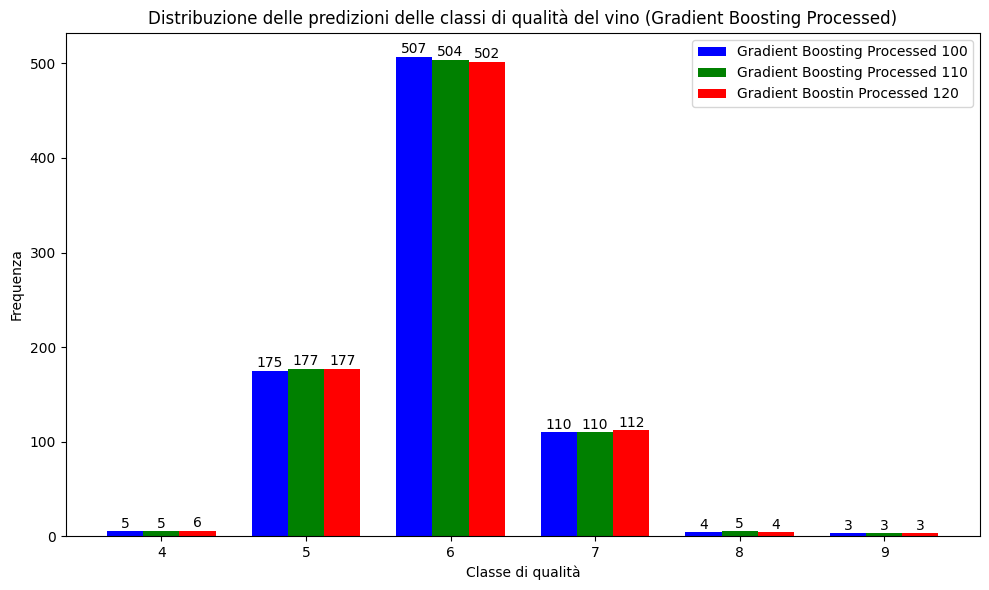

In [80]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boostin Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_processed_20.png"))
plt.show()

In [81]:
accuracy_100_20_gbp = accuracy_score(y_test_processed_1, y_pred_100_20_processed_gb)
accuracy_110_20_gbp = accuracy_score(y_test_processed_1, y_pred_110_20_processed_gb)
accuracy_120_20_gbp = accuracy_score(y_test_processed_1, y_pred_120_20_processed_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_20_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_20_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_20_gbp * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 61.32%
Accuratezza del modello Gradient Boosting con 110 estimatori: 61.57%
Accuratezza del modello Gradient Boosting con 120 estimatori: 61.94%


In [82]:
gb_100_processed.fit(x_train_processed_2_scaled, y_train_processed_2)
gb_110_processed.fit(x_train_processed_2_scaled, y_train_processed_2)
gb_120_processed.fit(x_train_processed_2_scaled, y_train_processed_2)

y_pred_100_25_processed_gb = gb_100_processed.predict(x_test_processed_2_scaled)
y_pred_110_25_processed_gb = gb_110_processed.predict(x_test_processed_2_scaled)
y_pred_120_25_processed_gb = gb_120_processed.predict(x_test_processed_2_scaled)

In [83]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_25_processed_gb:
    predict_value_gb_100[str(value)] += 1
predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_25_processed_gb:
    predict_value_gb_110[str(value)] += 1
predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_25_processed_gb:
    predict_value_gb_120[str(value)] += 1

In [84]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})

prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,6,7,7
5,245,246,242
6,602,597,598
7,144,147,151
8,6,6,5
9,1,1,1


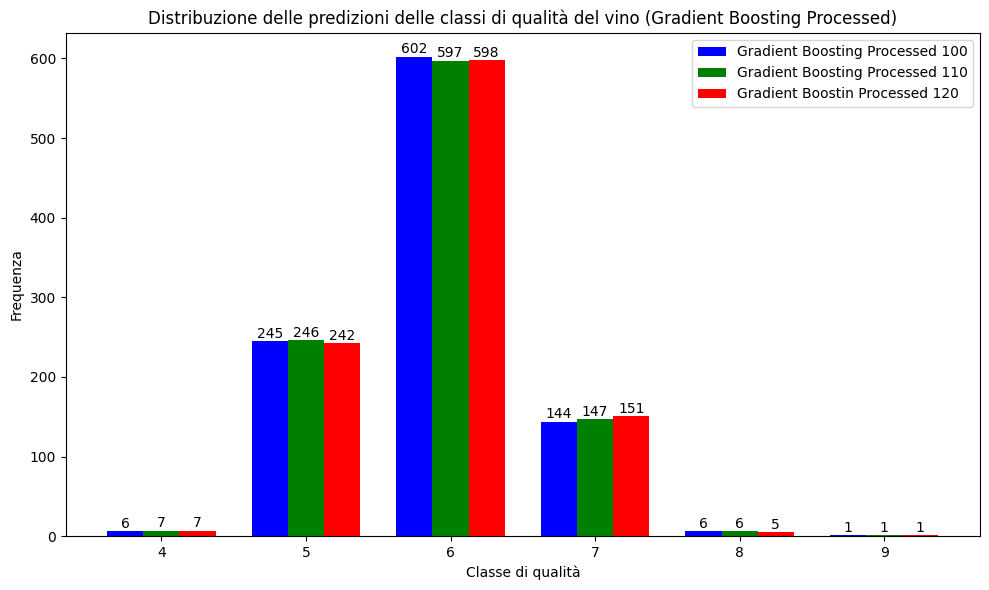

In [85]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boostin Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_processed_25.png"))
plt.show()

In [86]:
accuracy_100_25_gbp = accuracy_score(y_test_processed_2, y_pred_100_25_processed_gb)
accuracy_110_25_gbp = accuracy_score(y_test_processed_2, y_pred_110_25_processed_gb)
accuracy_120_25_gbp = accuracy_score(y_test_processed_2, y_pred_120_25_processed_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_25_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_25_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_25_gbp * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 60.86%
Accuratezza del modello Gradient Boosting con 110 estimatori: 60.96%
Accuratezza del modello Gradient Boosting con 120 estimatori: 61.45%


In [87]:
gb_100_processed.fit(x_train_processed_3_scaled, y_train_processed_3)
gb_110_processed.fit(x_train_processed_3_scaled, y_train_processed_3)
gb_120_processed.fit(x_train_processed_3_scaled, y_train_processed_3)

y_pred_100_30_processed_gb = gb_100_processed.predict(x_test_processed_3_scaled)
y_pred_110_30_processed_gb = gb_110_processed.predict(x_test_processed_3_scaled)
y_pred_120_30_processed_gb = gb_120_processed.predict(x_test_processed_3_scaled)

In [88]:
predict_value_gb_100 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_100_30_processed_gb:
    predict_value_gb_100[str(value)] += 1

predict_value_gb_110 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_110_30_processed_gb:
    predict_value_gb_110[str(value)] += 1

predict_value_gb_120 = dict.fromkeys(predict_value_rf, 0)
for value in y_pred_120_30_processed_gb:
    predict_value_gb_120[str(value)] += 1

In [89]:
prediction_df = pd.DataFrame({
    "Gradient Boosting 100": predict_value_gb_100,
    "Gradient Boosting 110": predict_value_gb_110,
    "Gradient Boosting 120": predict_value_gb_120
})

prediction_df

,Gradient Boosting 100,Gradient Boosting 110,Gradient Boosting 120
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,9,9,9
5,289,286,285
6,723,714,713
7,172,184,187
8,10,10,9
9,2,2,2


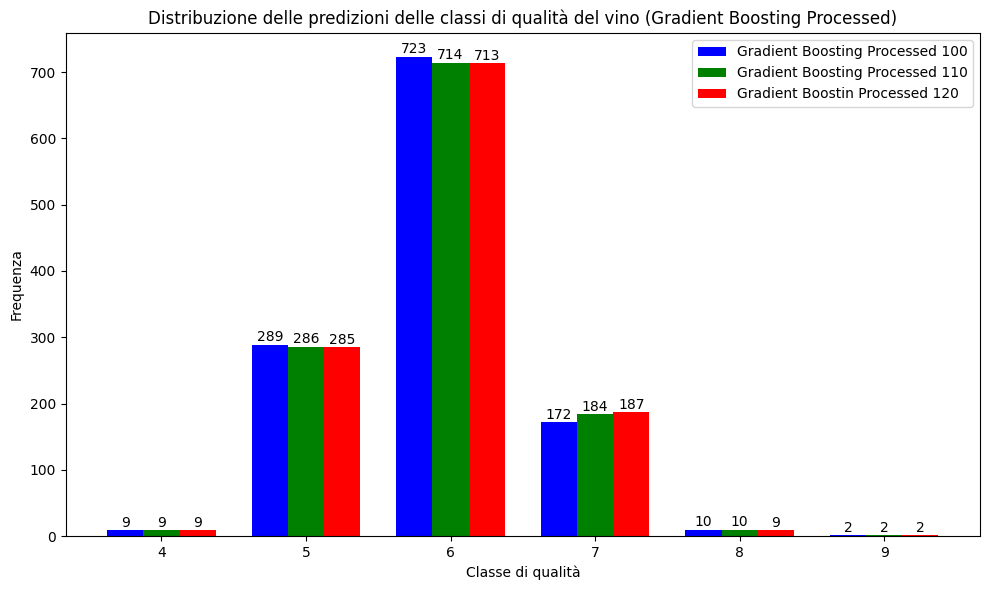

In [90]:
keys = list(predict_value_gb_100.keys())
vals_100 = np.array(list(predict_value_gb_100.values()))
vals_110 = np.array(list(predict_value_gb_110.values()))
vals_120 = np.array(list(predict_value_gb_120.values()))

mask = ~((vals_100 == 0) & (vals_110 == 0) & (vals_120 == 0))
filtered_keys = np.array(keys)[mask]
filtered_vals_100 = vals_100[mask]
filtered_vals_110 = vals_110[mask]
filtered_vals_120 = vals_120[mask]
filtered_index = range(len(filtered_keys))

plt.figure(figsize=(10, 6))
bar_width = 0.25
plt.bar([i - bar_width for i in filtered_index], filtered_vals_100, width=bar_width, label='Gradient Boosting Processed 100', color='b')
for i, v in enumerate(filtered_vals_100):
    plt.text(i - bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.bar(filtered_index, filtered_vals_110, width=bar_width, label='Gradient Boosting Processed 110', color='g')
for i, v in enumerate(filtered_vals_110):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.bar([i + bar_width for i in filtered_index], filtered_vals_120, width=bar_width, label='Gradient Boostin Processed 120', color='r')
for i, v in enumerate(filtered_vals_120):
    plt.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Classe di qualità')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle predizioni delle classi di qualità del vino (Gradient Boosting Processed)')
plt.xticks(filtered_index, filtered_keys)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "gb_quality_class_distribution_processed_30.png"))
plt.show()

In [91]:
accuracy_100_30_gbp = accuracy_score(y_test_processed_3, y_pred_100_30_processed_gb)
accuracy_110_30_gbp = accuracy_score(y_test_processed_3, y_pred_110_30_processed_gb)
accuracy_120_30_gbp = accuracy_score(y_test_processed_3, y_pred_120_30_processed_gb)
print(f"Accuratezza del modello Gradient Boosting con 100 estimatori: {accuracy_100_30_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 110 estimatori: {accuracy_110_30_gbp * 100 :.2f}%")
print(f"Accuratezza del modello Gradient Boosting con 120 estimatori: {accuracy_120_30_gbp * 100 :.2f}%")

Accuratezza del modello Gradient Boosting con 100 estimatori: 59.92%
Accuratezza del modello Gradient Boosting con 110 estimatori: 59.75%
Accuratezza del modello Gradient Boosting con 120 estimatori: 59.42%


# CONFRONTO FINALE TRA MODELLI

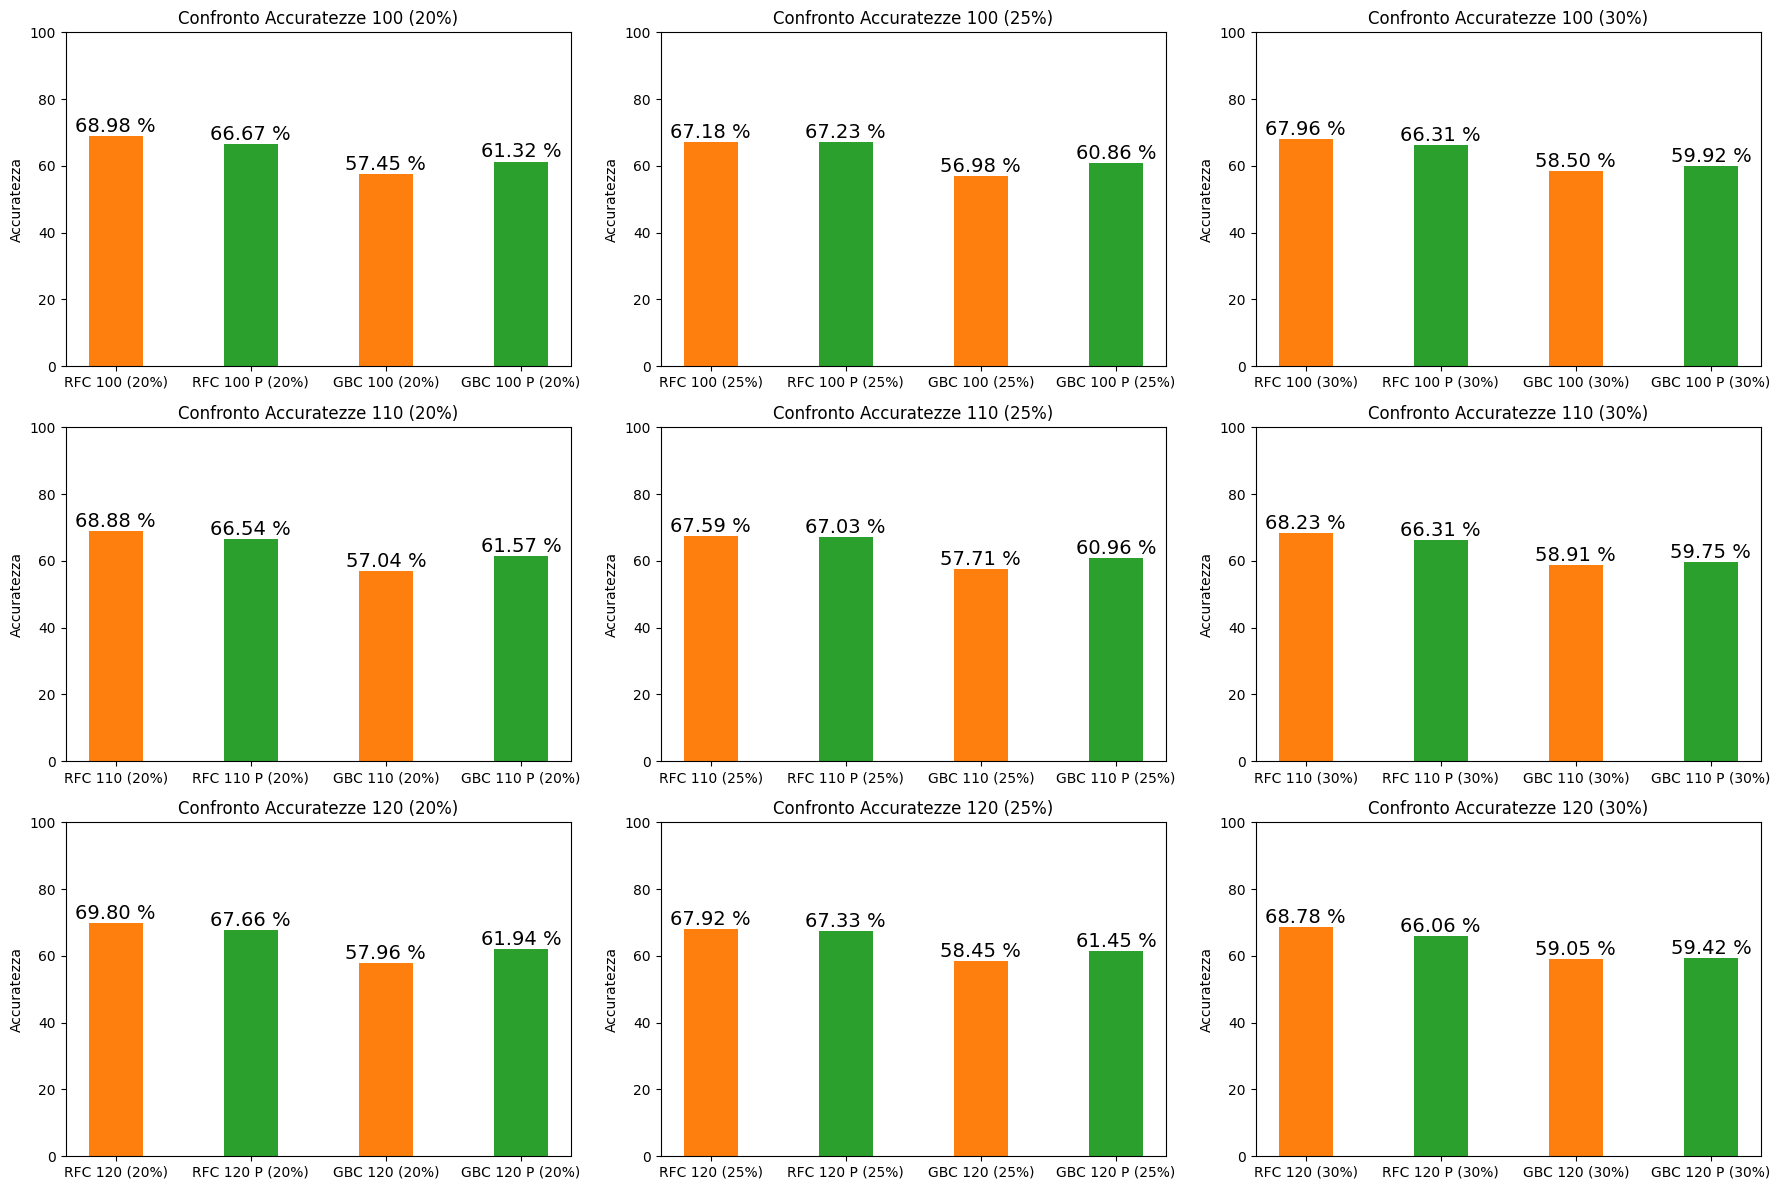

In [92]:
plt.figure(figsize=(18, 12))
colors = ['#ff7f0e', '#2ca02c']

models_test = [
    ['RFC 100 (20%)', 'RFC 100 P (20%)', 'GBC 100 (20%)', 'GBC 100 P (20%)'], 
    ['RFC 100 (25%)', 'RFC 100 P (25%)', 'GBC 100 (25%)', 'GBC 100 P (25%)'],
    ['RFC 100 (30%)', 'RFC 100 P (30%)', 'GBC 100 (30%)', 'GBC 100 P (30%)'],
    ['RFC 110 (20%)', 'RFC 110 P (20%)', 'GBC 110 (20%)', 'GBC 110 P (20%)'],
    ['RFC 110 (25%)', 'RFC 110 P (25%)', 'GBC 110 (25%)', 'GBC 110 P (25%)'],
    ['RFC 110 (30%)', 'RFC 110 P (30%)', 'GBC 110 (30%)', 'GBC 110 P (30%)'],
    ['RFC 120 (20%)', 'RFC 120 P (20%)', 'GBC 120 (20%)', 'GBC 120 P (20%)'],
    ['RFC 120 (25%)', 'RFC 120 P (25%)', 'GBC 120 (25%)', 'GBC 120 P (25%)'],
    ['RFC 120 (30%)', 'RFC 120 P (30%)', 'GBC 120 (30%)', 'GBC 120 P (30%)'],
]

accuracies_test = [
    [accuracy_100_20_rf*100, accuracy_100_20_rfp*100, accuracy_100_20_gb*100, accuracy_100_20_gbp*100],
    [accuracy_100_25_rf*100, accuracy_100_25_rfp*100, accuracy_100_25_gb*100, accuracy_100_25_gbp*100],
    [accuracy_100_30_rf*100, accuracy_100_30_rfp*100, accuracy_100_30_gb*100, accuracy_100_30_gbp*100],
    [accuracy_110_20_rf*100, accuracy_110_20_rfp*100, accuracy_110_20_gb*100, accuracy_110_20_gbp*100],
    [accuracy_110_25_rf*100, accuracy_110_25_rfp*100, accuracy_110_25_gb*100, accuracy_110_25_gbp*100],
    [accuracy_110_30_rf*100, accuracy_110_30_rfp*100, accuracy_110_30_gb*100, accuracy_110_30_gbp*100],
    [accuracy_120_20_rf*100, accuracy_120_20_rfp*100, accuracy_120_20_gb*100, accuracy_120_20_gbp*100],
    [accuracy_120_25_rf*100, accuracy_120_25_rfp*100, accuracy_120_25_gb*100, accuracy_120_25_gbp*100],
    [accuracy_120_30_rf*100, accuracy_120_30_rfp*100, accuracy_120_30_gb*100, accuracy_120_30_gbp*100],
]

for i in range(len(models_test)):
    plt.subplot(3, 3, i+1)
    bars = plt.bar(models_test[i], accuracies_test[i], color=colors, width=0.4, align='center')
    plt.title(f'Confronto Accuratezze {100 + (i // 3) * 10} ({20 + (i % 3) * 5}%)', fontsize=12)
    plt.ylabel('Accuratezza')
    plt.ylim(0, 100)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height+0.01, f'{height:.2f} %', ha='center', va='bottom', fontsize=14)

plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "accuracies_comparisons.png"))
plt.tight_layout()

In [93]:
y_true_20 = [
    #blocco dei test size 20%
    y_test_raw1, y_test_raw1, y_test_processed_1, y_test_processed_1,
    y_test_raw1, y_test_raw1, y_test_processed_1, y_test_processed_1,
    y_test_raw1, y_test_raw1, y_test_processed_1, y_test_processed_1,
]
y_true_25 = [
    #blocco dei test size 25%
    y_test_raw2, y_test_raw2, y_test_processed_2, y_test_processed_2,
    y_test_raw2, y_test_raw2, y_test_processed_2, y_test_processed_2,
    y_test_raw2, y_test_raw2, y_test_processed_2, y_test_processed_2,
]
y_true_30 = [
    #blocco dei test size 30%
    y_test_raw3, y_test_raw3, y_test_processed_3, y_test_processed_3,
    y_test_raw3, y_test_raw3, y_test_processed_3, y_test_processed_3,
    y_test_raw3, y_test_raw3, y_test_processed_3, y_test_processed_3
]

y_pred_20 = [
    #blocco dei test size 20%
    y_pred_100_20_raw_rf, y_pred_100_20_raw_gb, y_pred_100_20_processed_rf, y_pred_100_20_processed_gb,
    y_pred_110_20_raw_rf, y_pred_110_20_raw_gb, y_pred_110_20_processed_rf, y_pred_110_20_processed_gb,
    y_pred_120_20_raw_rf, y_pred_120_20_raw_gb, y_pred_120_20_processed_rf, y_pred_120_20_processed_gb,
]
y_pred_25 = [
    #blocco dei test size 25%
    y_pred_100_25_raw_rf, y_pred_100_25_raw_gb, y_pred_100_25_processed_rf, y_pred_100_25_processed_gb,
    y_pred_110_25_raw_rf, y_pred_110_25_raw_gb, y_pred_110_25_processed_rf, y_pred_110_25_processed_gb,
    y_pred_120_25_raw_rf, y_pred_120_25_raw_gb, y_pred_120_25_processed_rf, y_pred_120_25_processed_gb,
]
y_pred_30 = [
    #blocco dei test size 30%
    y_pred_100_30_raw_rf, y_pred_100_30_raw_gb, y_pred_100_30_processed_rf, y_pred_100_30_processed_gb,
    y_pred_110_30_raw_rf, y_pred_110_30_raw_gb, y_pred_110_30_processed_rf, y_pred_110_30_processed_gb,
    y_pred_120_30_raw_rf, y_pred_120_30_raw_gb, y_pred_120_30_processed_rf, y_pred_120_30_processed_gb
]

models_20 = [
    'RFC 100 20 (Raw)', 'GBC 100 20 (Raw)', 'RFC 100 20 (Processed)', 'GBC 100 20 (Processed)',
    'RFC 110 20 (Raw)', 'GBC 110 20 (Raw)', 'RFC 110 20 (Processed)', 'GBC 110 20 (Processed)',
    'RFC 120 20 (Raw)', 'GBC 120 20 (Raw)', 'RFC 120 20 (Processed)', 'GBC 120 20 (Processed)',
]
models_25 = [
    'RFC 100 25 (Raw)', 'GBC 100 25 (Raw)', 'RFC 100 25 (Processed)', 'GBC 100 25 (Processed)',
    'RFC 110 25 (Raw)', 'GBC 110 25 (Raw)', 'RFC 110 25 (Processed)', 'GBC 110 25 (Processed)',
    'RFC 120 25 (Raw)', 'GBC 120 25 (Raw)', 'RFC 120 25 (Processed)', 'GBC 120 25 (Processed)',
]
models_30 = [
    'RFC 100 30 (Raw)', 'GBC 100 30 (Raw)', 'RFC 100 30 (Processed)', 'GBC 100 30 (Processed)',
    'RFC 110 30 (Raw)', 'GBC 110 30 (Raw)', 'RFC 110 30 (Processed)', 'GBC 110 30 (Processed)',
    'RFC 120 30 (Raw)', 'GBC 120 30 (Raw)', 'RFC 120 30 (Processed)', 'GBC 120 30 (Processed)'

]

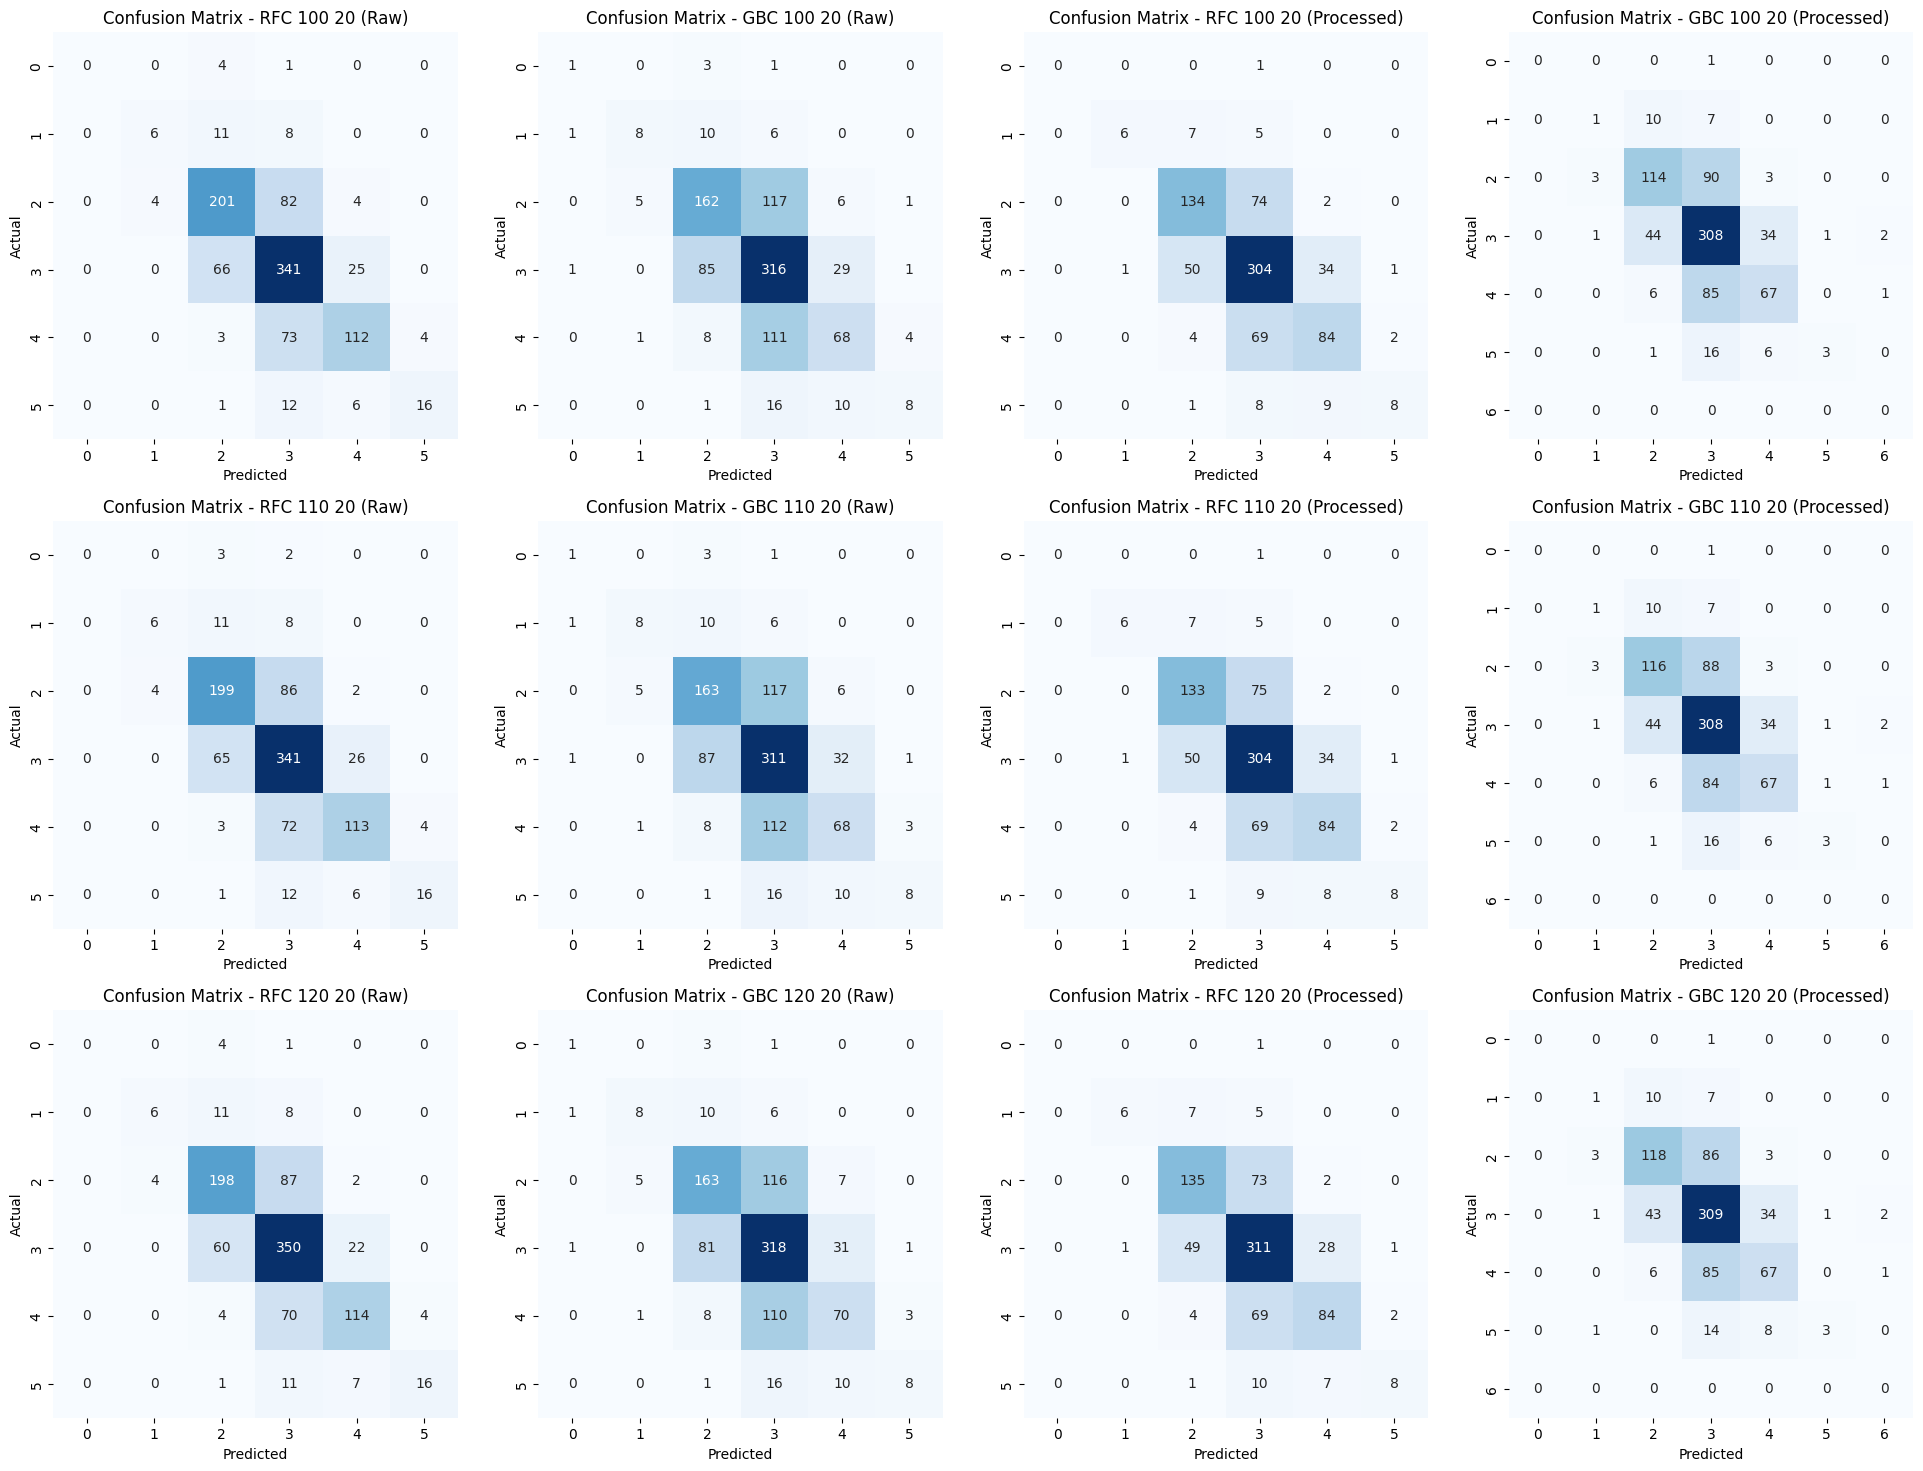

In [94]:
plt.figure(figsize=(24, 18))

for i in range(0, len(y_true_20)):
    plt.subplot(3, 4, i+1)
    cm_rf_100_20_raw = confusion_matrix(y_true_20[i], y_pred_20[i])
    sns.heatmap(cm_rf_100_20_raw, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {models_20[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "confusion_matrix_20.png"))


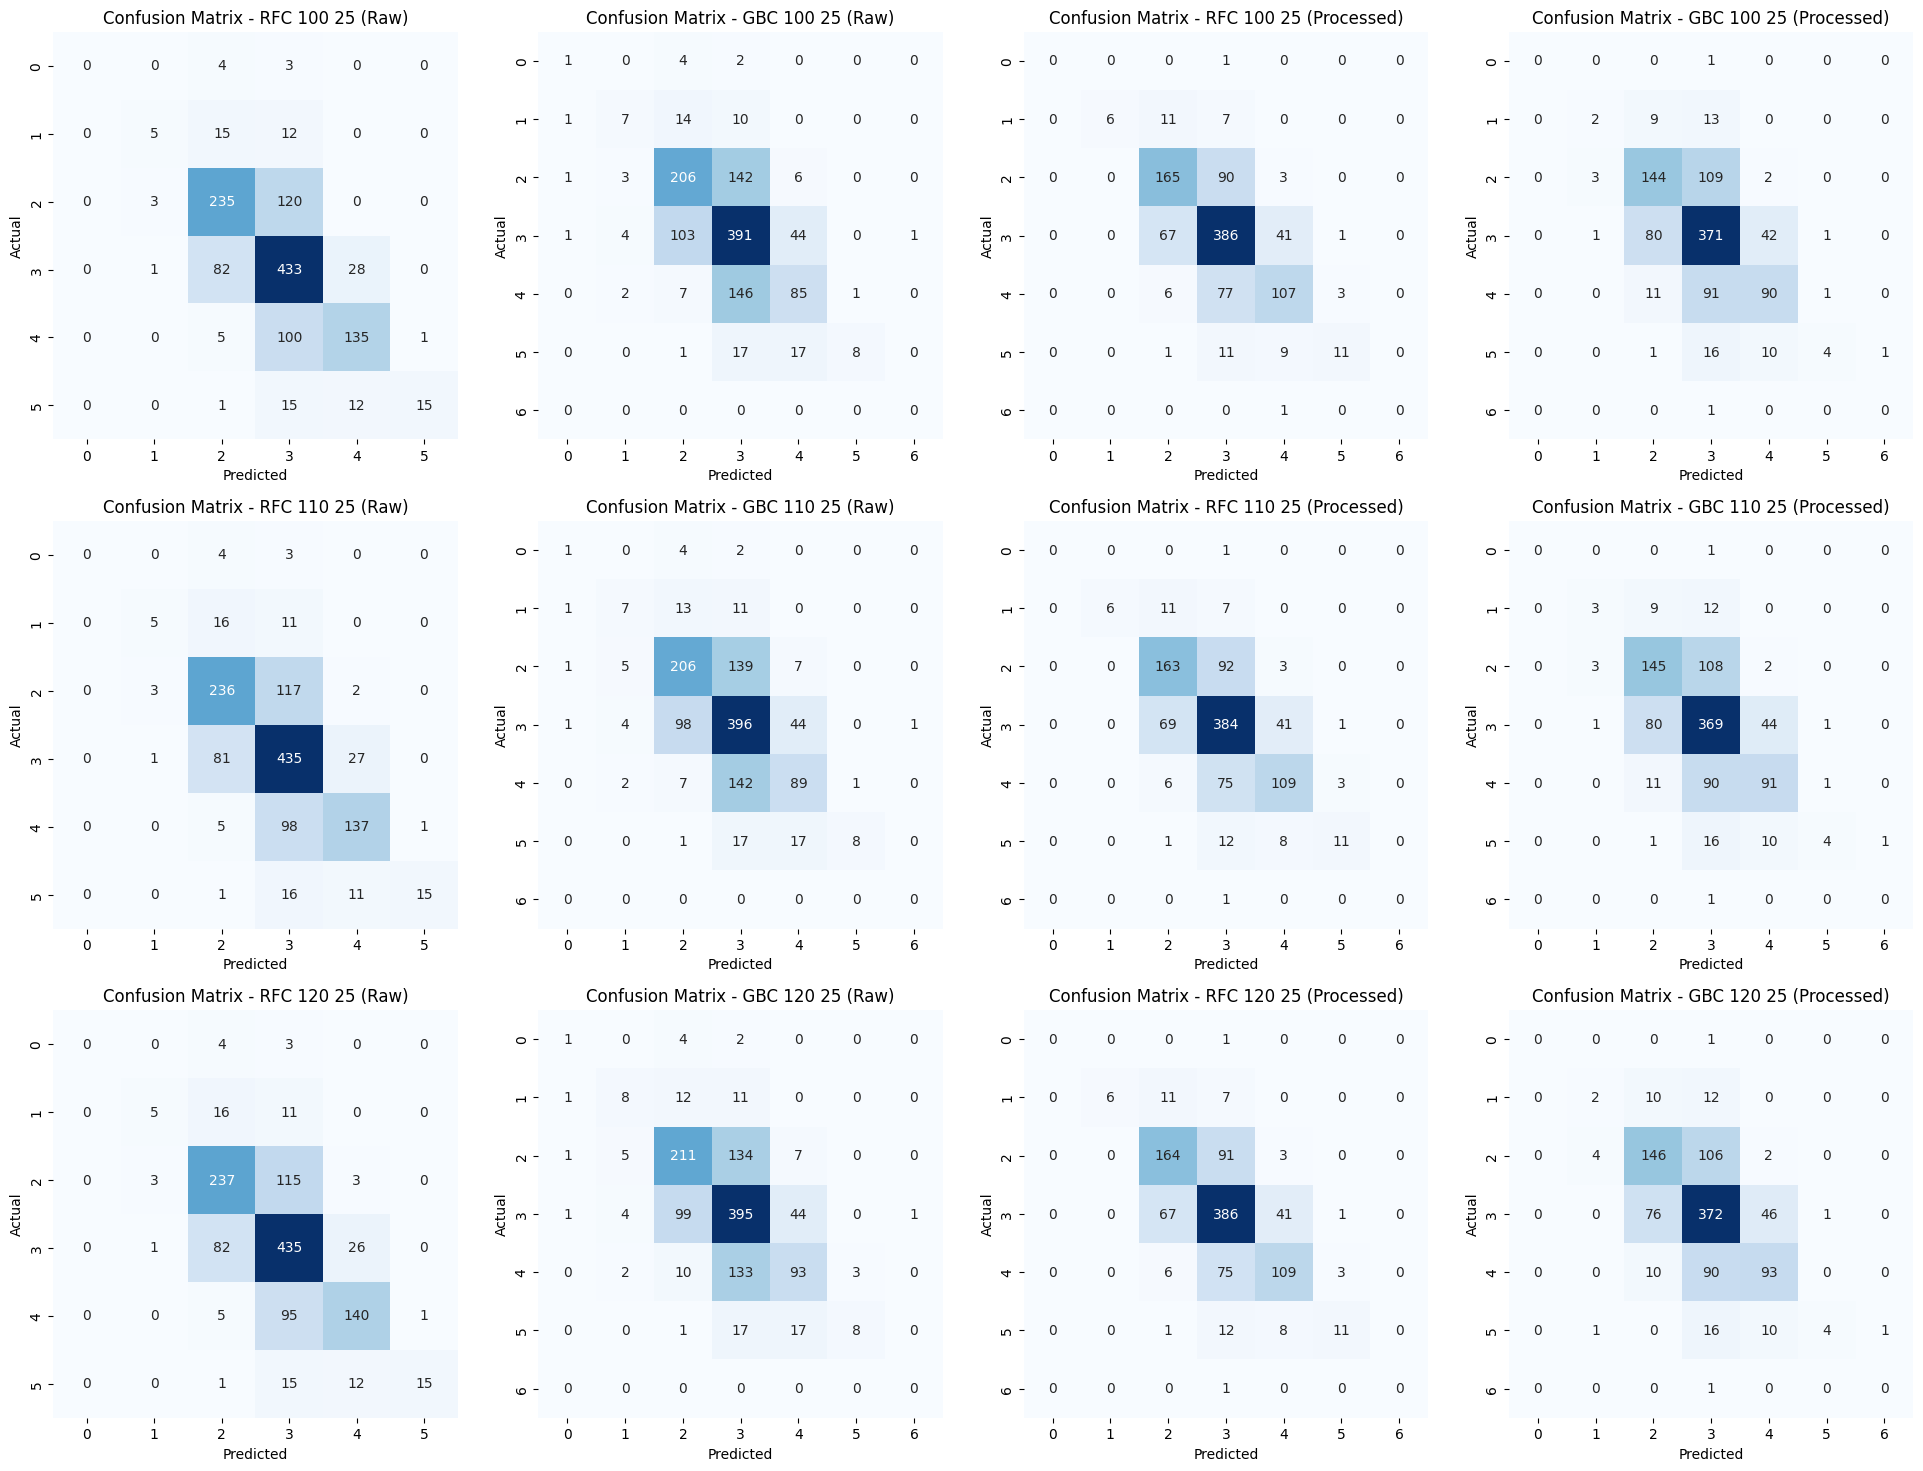

In [95]:
plt.figure(figsize=(24, 18))

for i in range(0, len(y_true_25)):
    plt.subplot(3, 4, i+1)
    cm_rf_100_25_raw = confusion_matrix(y_true_25[i], y_pred_25[i])
    sns.heatmap(cm_rf_100_25_raw, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {models_25[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "confusion_matrix_25.png"))

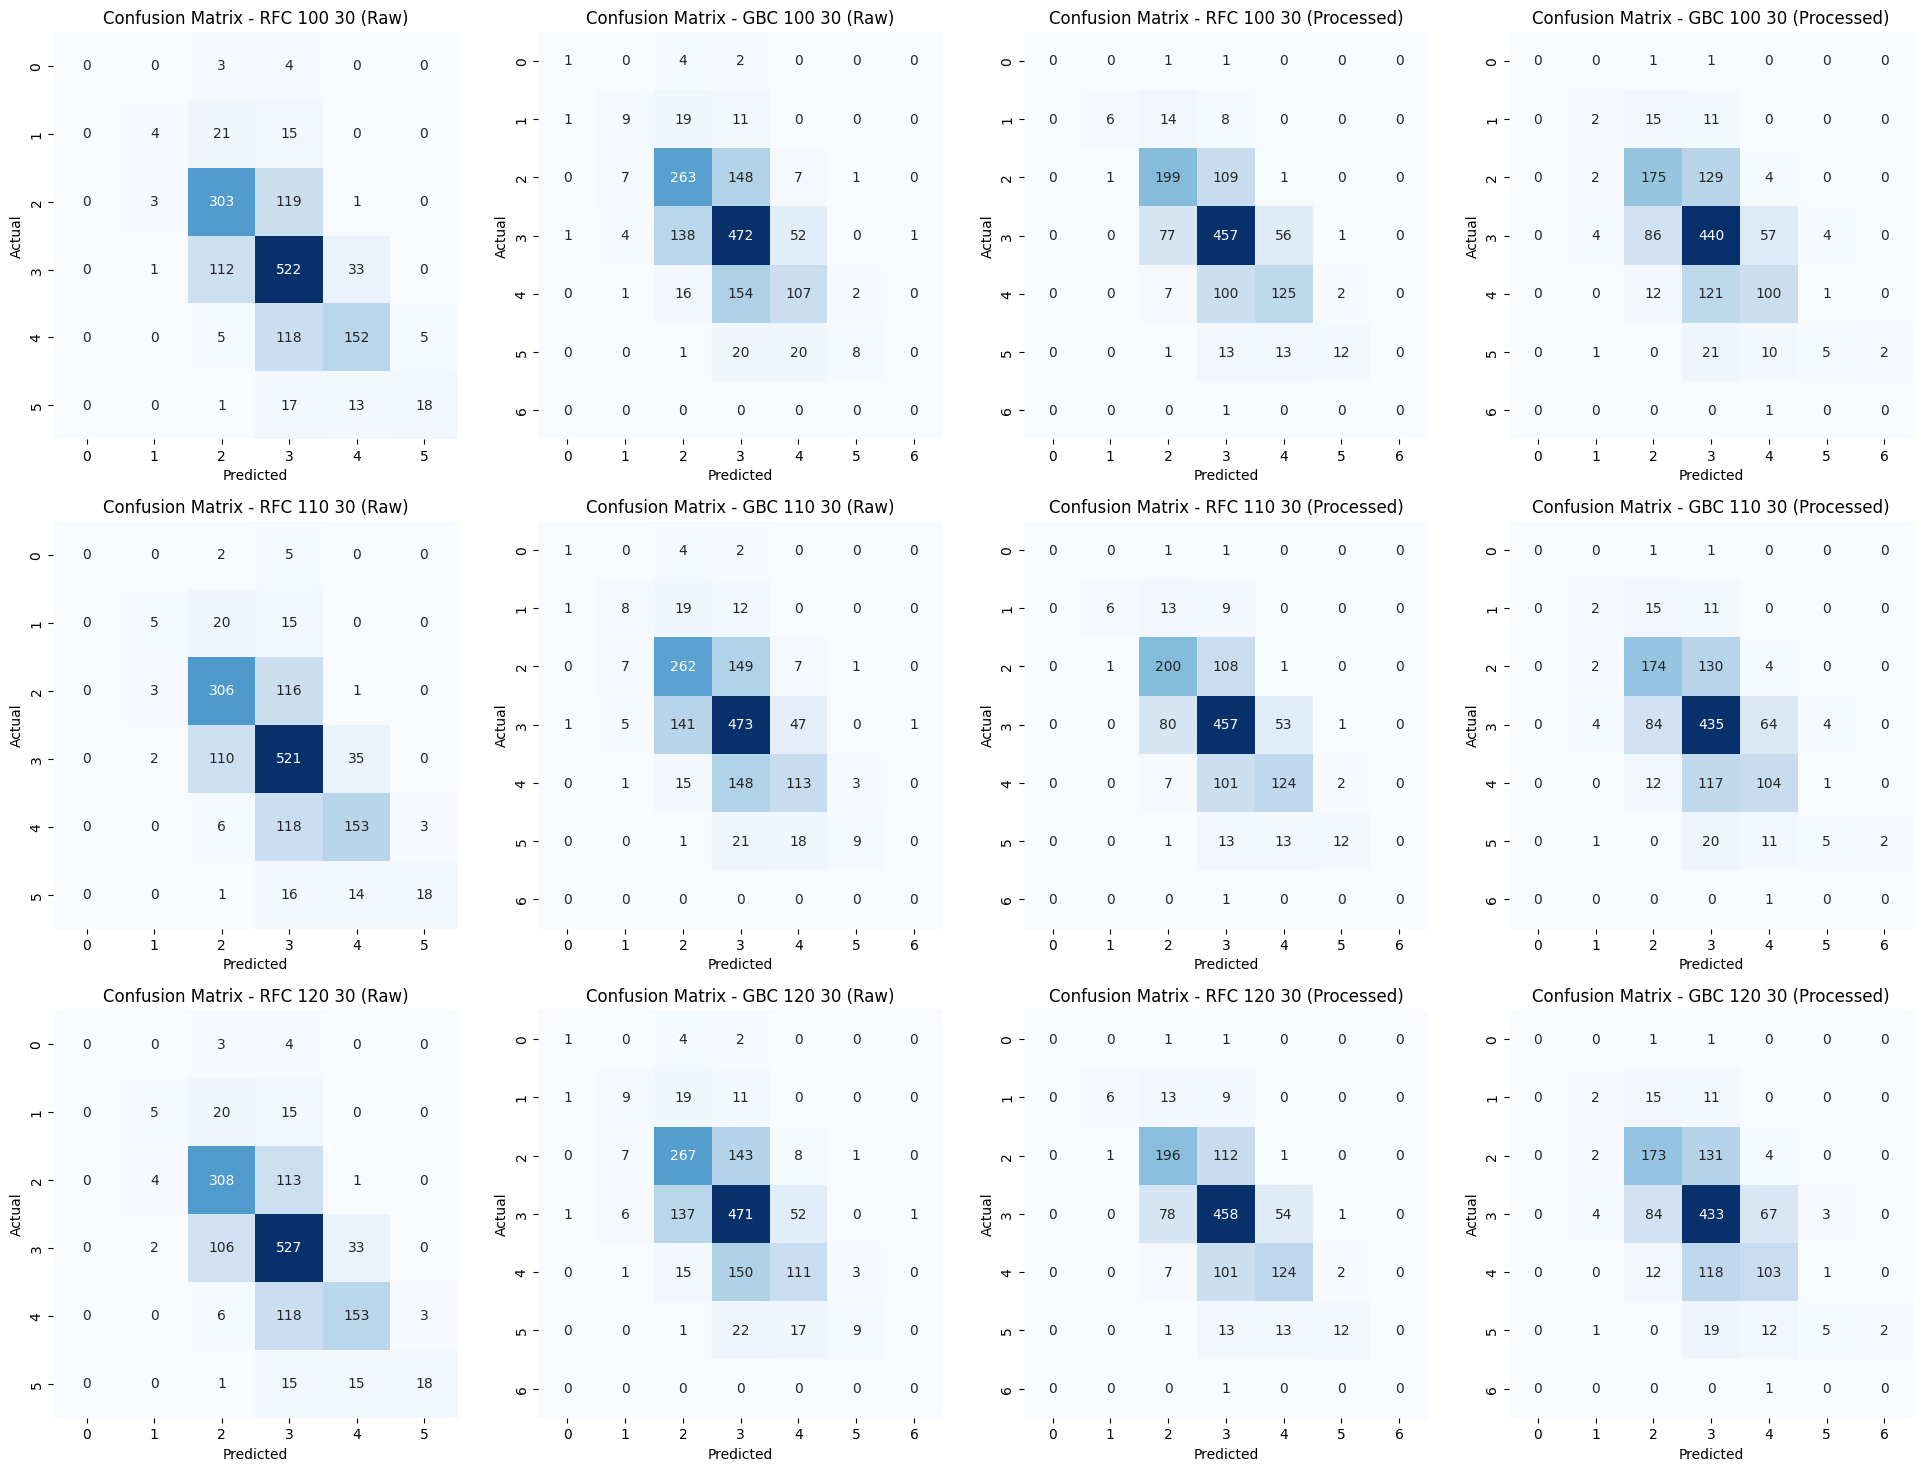

In [96]:
plt.figure(figsize=(24, 18))

for i in range(0, len(y_true_30)):
    plt.subplot(3, 4, i+1)
    cm_rf_100_30_raw = confusion_matrix(y_true_30[i], y_pred_30[i])
    sns.heatmap(cm_rf_100_30_raw, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {models_30[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.savefig(os.path.join(os.getcwd(), "immagini_progetto", "confusion_matrix_30.png"))